<a href="https://colab.research.google.com/github/IsaacFigNewton/Analyzing-Hate-Crime-Data/blob/main/Hate_Crime_Data_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TODO:
####Replace Anti-Church of Jesus Christ bias with Anti-Mormon
####Add county demographic data from other years
####Get p-values for in merged_df?
####Fix brittle transformation code
####Extract county-by-county hate crime frequency data

#Import Stuff

###Import all libraries

In [1]:
import pandas as pd
import sklearn as sk
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import altair as alt
import re
import warnings

###Import datasets

In [2]:
crime_df = pd.read_csv("https://raw.githubusercontent.com/IsaacFigNewton/Analyzing-Hate-Crime-Data/main/hate_crime/hate_crime.csv", on_bad_lines='skip')
county_demo_df = pd.read_csv("https://raw.githubusercontent.com/IsaacFigNewton/Analyzing-Hate-Crime-Data/main/demographics/county/ACSDP1Y2022.DP05-Data.csv", on_bad_lines='skip')

In [3]:
ethnicity_race_cols = list(set(pd.read_csv("https://raw.githubusercontent.com/IsaacFigNewton/Analyzing-Hate-Crime-Data/main/demographics/county/ethnicity_race_col_names", sep=";")["Percent!!RACE!!One race"]))
# ethnicity_race_cols

###Config

In [4]:
warnings.filterwarnings(action='ignore')

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [6]:
minimum_sample_size = 1

#Data Cleaning

In [7]:
#only consider county data from 2002-2022; had to expand scope since sample sizes were unreliably small using only 2022
crime_df = crime_df[(crime_df['data_year'] >= 2020) & ((crime_df['agency_type_name'] == "County"))]

In [8]:
crime_df.reset_index(inplace=True)

##Important Functions

In [9]:
def get_col_counts(df, unique_cols):
    # get the frequencies of categorical data based
    unique_col_counts = {}
    for value in unique_cols:
        if value in set(df.columns):
          unique_col_counts[value] = df[value].sum()
          # print(value)

    return unique_col_counts

In [10]:
def drop_outliers(df, numerical_cols, z_threshold=5):
    df_out = df.copy()  # Create a copy to avoid modifying the original DataFrame

    for column in numerical_cols:
        # Calculate Z-score for each value in the column
        z_scores = np.abs((df_out[column] - df_out[column].mean()) / df_out[column].std())

        print(z_scores.head())

        # Identify outliers based on Z-score
        outliers = df_out[z_scores > z_threshold]

        # Drop outliers from the DataFrame
        df_out = df_out.drop(outliers.index)

    return df_out

##Clean county demographic dataset

In [11]:
# use the entries of the first row as the column headers for easier management
def fixHeaders(df):
  new_headers = df.iloc[0]
  new_df = df[1:]
  new_df.columns = new_headers
  return new_df

In [12]:
#fix the headers
county_demo_df = fixHeaders(county_demo_df)

###Create area columns

In [13]:
def split_area_name(area):
    result = [np.nan, np.nan, np.nan]
    if ", " in area:
        result = area.split(", ") + [np.nan]
    if " city" in result[0].lower():
        result[0] = result[0][0:-5]
        result[2] = result[1]
        result[1] = "City"
    elif " county" in result[0].lower():
        result[0] = result[0][0:-7]
        result[2] = result[1]
        result[1] = "County"

    return result + [np.nan] * (3 - len(result))

def splitArea(df):
    df[["pug_agency_name", "agency_type_name", "state_name"]] = df["Geographic Area Name"].map(split_area_name).apply(pd.Series)

In [14]:
splitArea(county_demo_df)

###Fix column names



In [15]:
def fix_column_names(df):
  removalList = {"SEX AND AGE!!", "SEX AND ", "Estimate!!", "Total!!", "Total population!!", "CITIZEN, VOTING AGE POPULATION!!", "AGE!!"}

  new_cols = []
  for col in df.columns:
    col = str(col)
    for term in removalList:
      if term in col:
        col = col.replace(term, "")
    new_cols.append(col)

  return new_cols

county_demo_df.columns = fix_column_names(county_demo_df)

###Remove irrelevant/bad columns and rows to line the dataframes up

In [16]:
# fix any missing values
county_demo_df = county_demo_df.replace("(X)", np.nan)

In [17]:
#drop all margin of error columns from the county dataframe
def drop_cols_containing(df, pattern):
    df.drop(columns=list(df.filter(regex = pattern)), inplace = True)

drop_cols_containing(county_demo_df, "Margin of Error|SUMMARY INDICATORS|PERCENT ALLOCATED")

In [18]:
# Drop columns that only contain NaN values
new_county_df = county_demo_df.dropna(how='all', axis=1)

# get a list of the cols in the original df that aren't in the new one
dropped_cols = (set(county_demo_df.columns)).difference(set(new_county_df.columns))

# remove the deleted columns from ethnicity_race_cols
ethnicity_race_cols = list((set(ethnicity_race_cols)).difference(set(dropped_cols)))

county_demo_df = new_county_df

print(ethnicity_race_cols)

# Drop rows with NaN values in any of the ethnicity_race_cols
county_demo_df.dropna(subset=ethnicity_race_cols, how='any', inplace=True)

['Percent!!RACE!!One race!!Native Hawaiian and Other Pacific Islander!!Samoan', 'Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Some Other Race alone', 'Percent!!RACE!!One race!!Native Hawaiian and Other Pacific Islander', 'Percent!!RACE!!One race!!Asian!!Chinese', 'Percent!!RACE!!One race!!American Indian and Alaska Native!!Chippewa tribal grouping', 'Percent!!RACE!!One race!!American Indian and Alaska Native!!Navajo tribal grouping', 'Percent!!Race alone or in combination with one or more other races!!Some Other Race', 'Percent!!Race alone or in combination with one or more other races!!Asian', 'Percent!!Citizen, 18 and over population!!Male', 'Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Two or More Races', 'Percent!!RACE!!Two or More Races!!Black or African American and American Indian and Alaska Native', 'Percent!!RACE!!One race!!Asian!!Vietnamese', 'Percent!!Citizen, 18 and over population', 'Percent!!Race alone or in combination with one or more o

###Fix column data types

In [19]:
counts = county_demo_df.columns.value_counts()
mask = counts > 1
duplicates = list(counts[mask].index)
county_demo_df[duplicates].dtypes

RACE!!Two or More Races             object
RACE!!Two or More Races             object
65 years and over                   object
65 years and over                   object
18 years and over                   object
18 years and over                   object
Percent!!65 years and over          object
Percent!!65 years and over          object
Percent!!18 years and over          object
Percent!!18 years and over          object
Percent!!RACE!!One race             object
Percent!!RACE!!One race             object
Percent!!RACE!!Two or More Races    object
Percent!!RACE!!Two or More Races    object
RACE!!One race                      object
RACE!!One race                      object
dtype: object

In [20]:
county_demo_df = county_demo_df.loc[:, ~county_demo_df.columns.duplicated(keep='last')]

In [21]:
county_percent_age_cols = list(set(list(county_demo_df.filter(regex = "Percent"))\
                                  + list(county_demo_df.filter(regex = "ratio"))\
                                  + list(county_demo_df.filter(regex = "years"))))

for column in county_percent_age_cols:
    contaminated_indices_mask = county_demo_df[column]\
                                  .astype(str)\
                                  .str\
                                  .contains('N')
    county_demo_df.loc[contaminated_indices_mask, column] = 0

In [22]:
county_demo_df[county_percent_age_cols] = county_demo_df[county_percent_age_cols].astype(float)

In [23]:
county_demo_df[ethnicity_race_cols] = county_demo_df[ethnicity_race_cols].astype(float)

In [24]:
# Convert the quantitative columns to int types
# continuous quantitative variables
county_continuous_int_columns = ["Total population", "Under 5 years", "5 to 9 years", "45 to 54 years", "10 to 14 years", "75 to 84 years", "60 to 64 years",\
                      "25 to 34 years", "15 to 19 years", "20 to 24 years", "35 to 44 years", "55 to 59 years", "65 to 74 years",\
                      "85 years and over"] + ethnicity_race_cols

county_demo_df[county_continuous_int_columns].replace("N", 0, inplace=True)


county_demo_df[county_continuous_int_columns] = county_demo_df[county_continuous_int_columns].astype(int)

In [25]:
age_groups = ['Under 5 years', '5 to 9 years', '10 to 14 years', '15 to 19 years', '20 to 24 years', '25 to 34 years', '35 to 44 years', '45 to 54 years', '55 to 59 years', '60 to 64 years', '65 to 74 years', '75 to 84 years', '85 years and over']

###Drop outliers

In [26]:
county_demo_df = drop_outliers(county_demo_df, county_continuous_int_columns)

1    0.157401
2    0.382892
3    0.426253
4    0.458471
5    0.428155
Name: Total population, dtype: float64
1    0.199035
2    0.462440
3    0.516623
4    0.580016
5    0.558199
Name: Under 5 years, dtype: float64
1    0.063708
2    0.615537
3    0.593420
4    0.631218
5    0.659715
Name: 5 to 9 years, dtype: float64
1    0.033780
2    0.514066
3    0.595648
4    0.666173
5    0.588687
Name: 45 to 54 years, dtype: float64
1    0.198579
2    0.538769
3    0.665023
4    0.704145
5    0.587164
Name: 10 to 14 years, dtype: float64
1    0.134342
2    0.511712
3    0.579852
4    0.664520
5    0.620814
Name: 75 to 84 years, dtype: float64
1    0.176726
2    0.565786
3    0.644744
4    0.727207
5    0.627907
Name: 60 to 64 years, dtype: float64
1    0.199287
2    0.520925
3    0.585056
4    0.678545
5    0.557784
Name: 25 to 34 years, dtype: float64
1    0.209678
2    0.532807
3    0.682111
4    0.694917
5    0.708067
Name: 15 to 19 years, dtype: float64
1    0.338651
2    0.471923
3    0.712

In [27]:
county_demo_df["Geography"].count()

662

##Clean crime dataset

In [28]:
crime_continuous_int_columns = ["index", "incident_id", "data_year"] + list(crime_df.select_dtypes("float64").columns)

In [29]:
crime_df[crime_continuous_int_columns].head()

index  incident_id  data_year  adult_victim_count  juvenile_victim_count  \
0  209205      1401052       2020                 0.0                    0.0   
1  209206      1403751       2020                 0.0                    0.0   
2  209210      1455329       2020                 1.0                    0.0   
3  209211      1455330       2020                 1.0                    0.0   
4  209213      1455332       2020                 0.0                    0.0   

   adult_offender_count  juvenile_offender_count  total_individual_victims  
0                   2.0                      0.0                       0.0  
1                   3.0                      1.0                       0.0  
2                   1.0                      0.0                       1.0  
3                   1.0                      0.0                       1.0  
4                   1.0                      0.0                       0.0

In [30]:
crime_continuous_int_columns

['index',
 'incident_id',
 'data_year',
 'adult_victim_count',
 'juvenile_victim_count',
 'adult_offender_count',
 'juvenile_offender_count',
 'total_individual_victims']

###Drop outliers

In [31]:
crime_df.head()

index  incident_id  data_year        ori pug_agency_name pub_agency_unit  \
0  209205      1401052       2020  AL0650000      Washington             NaN   
1  209206      1403751       2020  AL0270000          Dallas             NaN   
2  209210      1455329       2020  AL0240000        Crenshaw             NaN   
3  209211      1455330       2020  AL0280000          DeKalb             NaN   
4  209213      1455332       2020  AL0650000      Washington             NaN   

  agency_type_name state_abbr state_name       division_name region_name  \
0           County         AL    Alabama  East South Central       South   
1           County         AL    Alabama  East South Central       South   
2           County         AL    Alabama  East South Central       South   
3           County         AL    Alabama  East South Central       South   
4           County         AL    Alabama  East South Central       South   

  population_group_code              population_group_description  \
0                    9C      MSA counties from 10,000 thru 24,999   
1                    8C  Non-MSA counties from 10,000 thru 24,999   
2                    8D             Non-MSA counties under 10,000   
3                    8B  Non-MSA counties from 25,000 thru 99,999   
4                    9C      MSA counties from 10,000 thru 24,999   

  incident_date  adult_victim_count  juvenile_victim_count  \
0    2020-02-08                 0.0                    0.0   
1    2020-03-17                 0.0                    0.0   
2    2020-01-18                 1.0                    0.0   
3    2020-05-04                 1.0                    0.0   
4    2020-03-16                 0.0                    0.0   

   total_offender_count  adult_offender_count  juvenile_offender_count  \
0                     2                   2.0                      0.0   
1                     4                   3.0                      1.0   
2                     1                   1.0                      0.0   
3                     1                   1.0                      0.0   
4                     1                   1.0                      0.0   

  offender_race      offender_ethnicity  victim_count  \
0         White  Not Hispanic or Latino             2   
1       Unknown           Not Specified             1   
2         White  Not Hispanic or Latino             1   
3         White           Not Specified             1   
4         White  Not Hispanic or Latino             1   

                                        offense_name  \
0  Drug Equipment Violations;Drug/Narcotic Violat...   
1                          Drug Equipment Violations   
2                       Burglary/Breaking & Entering   
3                                     Simple Assault   
4                          Drug Equipment Violations   

   total_individual_victims                                  location_name  \
0                       0.0             Highway/Road/Alley/Street/Sidewalk   
1                       0.0  Jail/Prison/Penitentiary/Corrections Facility   
2                       1.0                                 Residence/Home   
3                       1.0                                 Residence/Home   
4                       0.0             Highway/Road/Alley/Street/Sidewalk   

    bias_desc    victim_types multiple_offense multiple_bias  
0  Anti-White  Society/Public                M             S  
1  Anti-White  Society/Public                S             S  
2  Anti-White      Individual                S             S  
3  Anti-White      Individual                S             S  
4  Anti-White  Society/Public                S             S

In [32]:
# crime_df.reset_index(inplace=True)
crime_df = drop_outliers(crime_df, crime_continuous_int_columns)

0    1.785958
1    1.785851
2    1.785422
3    1.785314
4    1.785099
Name: index, dtype: float64
0    0.666442
1    0.629931
2    0.067795
3    0.067808
4    0.067835
Name: incident_id, dtype: float64
0    1.353079
1    1.353079
2    1.353079
3    1.353079
4    1.353079
Name: data_year, dtype: float64
0    1.164685
1    1.164685
2    0.159907
3    0.159907
4    1.164685
Name: adult_victim_count, dtype: float64
0    0.3186
1    0.3186
2    0.3186
3    0.3186
4    0.3186
Name: juvenile_victim_count, dtype: float64
0    1.416041
1    2.723281
2    0.108801
3    0.108801
4    0.108801
Name: adult_offender_count, dtype: float64
0    0.327530
1    1.220751
2    0.327530
3    0.327530
4    0.327530
Name: juvenile_offender_count, dtype: float64
0    1.545817
1    1.545817
2    0.025757
3    0.025757
4    1.545817
Name: total_individual_victims, dtype: float64


In [33]:
crime_df.head()

index  incident_id  data_year        ori pug_agency_name pub_agency_unit  \
0  209205      1401052       2020  AL0650000      Washington             NaN   
1  209206      1403751       2020  AL0270000          Dallas             NaN   
2  209210      1455329       2020  AL0240000        Crenshaw             NaN   
3  209211      1455330       2020  AL0280000          DeKalb             NaN   
4  209213      1455332       2020  AL0650000      Washington             NaN   

  agency_type_name state_abbr state_name       division_name region_name  \
0           County         AL    Alabama  East South Central       South   
1           County         AL    Alabama  East South Central       South   
2           County         AL    Alabama  East South Central       South   
3           County         AL    Alabama  East South Central       South   
4           County         AL    Alabama  East South Central       South   

  population_group_code              population_group_description  \
0                    9C      MSA counties from 10,000 thru 24,999   
1                    8C  Non-MSA counties from 10,000 thru 24,999   
2                    8D             Non-MSA counties under 10,000   
3                    8B  Non-MSA counties from 25,000 thru 99,999   
4                    9C      MSA counties from 10,000 thru 24,999   

  incident_date  adult_victim_count  juvenile_victim_count  \
0    2020-02-08                 0.0                    0.0   
1    2020-03-17                 0.0                    0.0   
2    2020-01-18                 1.0                    0.0   
3    2020-05-04                 1.0                    0.0   
4    2020-03-16                 0.0                    0.0   

   total_offender_count  adult_offender_count  juvenile_offender_count  \
0                     2                   2.0                      0.0   
1                     4                   3.0                      1.0   
2                     1                   1.0                      0.0   
3                     1                   1.0                      0.0   
4                     1                   1.0                      0.0   

  offender_race      offender_ethnicity  victim_count  \
0         White  Not Hispanic or Latino             2   
1       Unknown           Not Specified             1   
2         White  Not Hispanic or Latino             1   
3         White           Not Specified             1   
4         White  Not Hispanic or Latino             1   

                                        offense_name  \
0  Drug Equipment Violations;Drug/Narcotic Violat...   
1                          Drug Equipment Violations   
2                       Burglary/Breaking & Entering   
3                                     Simple Assault   
4                          Drug Equipment Violations   

   total_individual_victims                                  location_name  \
0                       0.0             Highway/Road/Alley/Street/Sidewalk   
1                       0.0  Jail/Prison/Penitentiary/Corrections Facility   
2                       1.0                                 Residence/Home   
3                       1.0                                 Residence/Home   
4                       0.0             Highway/Road/Alley/Street/Sidewalk   

    bias_desc    victim_types multiple_offense multiple_bias  
0  Anti-White  Society/Public                M             S  
1  Anti-White  Society/Public                S             S  
2  Anti-White      Individual                S             S  
3  Anti-White      Individual                S             S  
4  Anti-White  Society/Public                S             S

###Break up incident date information

In [34]:
def split_incident_date(date):
    result = date.split("-")

    return result + [np.nan] * (3 - len(result))

crime_df[["data_year", "incident_month", "incident_day"]] = crime_df["incident_date"]\
                                                              .map(split_incident_date)\
                                                              .apply(pd.Series)\
                                                              .astype(int)

In [35]:
crime_df[["data_year", "incident_month", "incident_day"]].dtypes

data_year         int64
incident_month    int64
incident_day      int64
dtype: object

###Break up crime_df categorical columns containing multiple categories into dummies

In [36]:
def multicol_parse(df, column, delimiter):
  prefix = column + "_"

  dummies = df[column]\
              .str\
              .get_dummies(sep=delimiter)\
              .add_prefix(prefix)
  dummies = dummies.astype(int)
  dummies.head()

  dummy_cols = list(dummies.columns)
  unique_values = [val.replace(prefix, "") for val in dummy_cols]

  # combine the dataframes
  new_df = pd.concat([df, dummies], axis=1)

  return unique_values, dummy_cols, new_df

In [37]:
crime_df.reset_index(inplace=True)

In [38]:
#Break up bias_desc column into dummy columns
unique_biases, bias_cols, crime_df = multicol_parse(crime_df, "bias_desc", ";")

In [39]:
#Break up victim_types column into dummy columns
unique_victim_types, victim_cols, crime_df = multicol_parse(crime_df, "victim_types", ";")

In [40]:
#Break up offense_names column into dummy columns
unique_offense_names, offense_cols, crime_df = multicol_parse(crime_df, "offense_name", ";")

In [41]:
#Break up location_names column into dummy columns
unique_location_names, location_cols, crime_df = multicol_parse(crime_df, "location_name", ";")

###Create dummy columns for other categorical variables

In [42]:
other_categorical_cols = ["pug_agency_name", "agency_type_name", "division_name", "offender_race",
                          "offender_ethnicity", "state_name", "multiple_offense", "multiple_bias"]

In [43]:
other_categorical_cols

['pug_agency_name',
 'agency_type_name',
 'division_name',
 'offender_race',
 'offender_ethnicity',
 'state_name',
 'multiple_offense',
 'multiple_bias']

In [44]:
crime_df.head()

level_0   index  incident_id  data_year        ori pug_agency_name  \
0        0  209205      1401052       2020  AL0650000      Washington   
1        1  209206      1403751       2020  AL0270000          Dallas   
2        2  209210      1455329       2020  AL0240000        Crenshaw   
3        3  209211      1455330       2020  AL0280000          DeKalb   
4        4  209213      1455332       2020  AL0650000      Washington   

  pub_agency_unit agency_type_name state_abbr state_name       division_name  \
0             NaN           County         AL    Alabama  East South Central   
1             NaN           County         AL    Alabama  East South Central   
2             NaN           County         AL    Alabama  East South Central   
3             NaN           County         AL    Alabama  East South Central   
4             NaN           County         AL    Alabama  East South Central   

  region_name population_group_code              population_group_description  \
0       South                    9C      MSA counties from 10,000 thru 24,999   
1       South                    8C  Non-MSA counties from 10,000 thru 24,999   
2       South                    8D             Non-MSA counties under 10,000   
3       South                    8B  Non-MSA counties from 25,000 thru 99,999   
4       South                    9C      MSA counties from 10,000 thru 24,999   

  incident_date  adult_victim_count  juvenile_victim_count  \
0    2020-02-08                 0.0                    0.0   
1    2020-03-17                 0.0                    0.0   
2    2020-01-18                 1.0                    0.0   
3    2020-05-04                 1.0                    0.0   
4    2020-03-16                 0.0                    0.0   

   total_offender_count  adult_offender_count  juvenile_offender_count  \
0                     2                   2.0                      0.0   
1                     4                   3.0                      1.0   
2                     1                   1.0                      0.0   
3                     1                   1.0                      0.0   
4                     1                   1.0                      0.0   

  offender_race      offender_ethnicity  victim_count  \
0         White  Not Hispanic or Latino             2   
1       Unknown           Not Specified             1   
2         White  Not Hispanic or Latino             1   
3         White           Not Specified             1   
4         White  Not Hispanic or Latino             1   

                                        offense_name  \
0  Drug Equipment Violations;Drug/Narcotic Violat...   
1                          Drug Equipment Violations   
2                       Burglary/Breaking & Entering   
3                                     Simple Assault   
4                          Drug Equipment Violations   

   total_individual_victims                                  location_name  \
0                       0.0             Highway/Road/Alley/Street/Sidewalk   
1                       0.0  Jail/Prison/Penitentiary/Corrections Facility   
2                       1.0                                 Residence/Home   
3                       1.0                                 Residence/Home   
4                       0.0             Highway/Road/Alley/Street/Sidewalk   

    bias_desc    victim_types multiple_offense multiple_bias  incident_month  \
0  Anti-White  Society/Public                M             S               2   
1  Anti-White  Society/Public                S             S               3   
2  Anti-White      Individual                S             S               1   
3  Anti-White      Individual                S             S               5   
4  Anti-White  Society/Public                S             S               3   

   incident_day  bias_desc_Anti-American Indian or Alaska Native  \
0             8                                                0   
1           

In [45]:
other_unique_categorical_cols = {}
for col in other_categorical_cols:
    unique_values = crime_df[col].unique()
    # print(unique_values)
    other_unique_categorical_cols[col] = [col + "_" + str(val) for val in unique_values]
print(other_unique_categorical_cols["pug_agency_name"])

['pug_agency_name_Washington', 'pug_agency_name_Dallas', 'pug_agency_name_Crenshaw', 'pug_agency_name_DeKalb', 'pug_agency_name_Walker', 'pug_agency_name_Etowah', 'pug_agency_name_Sebastian', 'pug_agency_name_Polk', 'pug_agency_name_Izard', 'pug_agency_name_Coconino', 'pug_agency_name_Yavapai', 'pug_agency_name_Yuma', 'pug_agency_name_Pima', 'pug_agency_name_San Diego', 'pug_agency_name_Yolo', 'pug_agency_name_Santa Clara', 'pug_agency_name_Sonoma', 'pug_agency_name_Tuolumne', 'pug_agency_name_Los Angeles', 'pug_agency_name_Sacramento', 'pug_agency_name_Marin', 'pug_agency_name_Lake', 'pug_agency_name_El Dorado', 'pug_agency_name_San Bernardino', 'pug_agency_name_Stanislaus', 'pug_agency_name_Orange', 'pug_agency_name_Fresno', 'pug_agency_name_Santa Cruz', 'pug_agency_name_Alameda', 'pug_agency_name_Santa Barbara', 'pug_agency_name_Butte', 'pug_agency_name_Contra Costa', 'pug_agency_name_Yuba', 'pug_agency_name_Amador', 'pug_agency_name_San Luis Obispo', 'pug_agency_name_San Mateo', 'p

In [46]:
dummies = pd.get_dummies(crime_df[other_categorical_cols]).astype(int)
dummies.drop(columns=['multiple_offense_S', 'multiple_bias_S'], inplace=True)
other_unique_categorical_cols["multiple_offense"] = ["multiple_offense_M"]
other_unique_categorical_cols["multiple_bias"] = ["multiple_bias_M"]

# combine the dummy columns with crime_df
crime_df = pd.concat([crime_df, dummies], axis=1)

###List the categorical columns

In [47]:
# break up other_unique_categorical_cols because Python is being stupid
crime_categorical_cols = bias_cols\
                          + victim_cols\
                          + offense_cols\
                          + location_cols
for key, value in other_unique_categorical_cols.items():
  crime_categorical_cols += value
                          # + list(other_unique_categorical_cols.values())  #[col for i, col in enumerate(other_unique_categorical_cols.values())]

In [48]:
# parse the cols because python is being really friggin stupid in the cell above and I have no idea why
# crime_categorical_cols = str(crime_categorical_cols)\
#                           .replace("[", "")\
#                           .replace("]", "")\
#                           .split("', '")
# crime_categorical_cols[0] = crime_categorical_cols[0][1:-1] + "e"
# crime_categorical_cols[-1] = crime_categorical_cols[-1][0:-1]

# crime_categorical_cols

#Data Processing

##Perform power transformations and normalize data

###Transform data to Gaussian distributions

In [49]:
def transform_standardize_data(df, numerical_cols, categorical_cols):
  # increase subsampling size if df is bigger than the default size
  n_quantiles = len(df)
  subsample = 10000
  if n_quantiles > subsample:
    subsample = n_quantiles * 10

  print("Performing quantile transformation process...")
  # use a quantile transformer to normalize the data and since the PowerTransformer keeps shitting itself
  scaler = sk.preprocessing.QuantileTransformer(output_distribution="normal", n_quantiles=n_quantiles, subsample=subsample)
  transformed_data = scaler.fit_transform(df[numerical_cols])

  print("Renaming numerical columns...")
  for i, col in enumerate(numerical_cols):
    new_column_header = "transformed_" + col

    # update the list of numerical column labels
    numerical_cols[i] = new_column_header
    # add the transformed, standardized data back to the original dataframe
    df[new_column_header] = transformed_data[:, i]

  print("Dropping categorical columns with insufficient sample size...")
  # identify columns with insufficient sample sizes
  columns_to_drop = []
  for col in categorical_cols:
      if df[col].sum() < minimum_sample_size:
          columns_to_drop.append(col)

  # drop identified columns
  df.drop(columns_to_drop, axis=1, inplace=True)

  # update categorical_cols after dropping
  categorical_cols = [col for col in categorical_cols if col not in columns_to_drop]

In [50]:
crime_numerical_cols = list(crime_df.select_dtypes(include=['int64', 'float64']).columns)
county_numerical_cols = list(county_demo_df.select_dtypes(include=["int64", "float64"]).columns)

In [51]:
# yeo-johnson transformation is super brittle and I'm not sure why
#transform the county data
transform_standardize_data(county_demo_df, county_numerical_cols, [])

Performing quantile transformation process...
Renaming numerical columns...
Dropping categorical columns with insufficient sample size...


In [52]:
#transform the non-categorical data of crime_df
transform_standardize_data(crime_df,\
                            [col for col in crime_numerical_cols\
                                      if not col in crime_categorical_cols],\
                            crime_categorical_cols)

Performing quantile transformation process...
Renaming numerical columns...
Dropping categorical columns with insufficient sample size...


In [53]:
# remove columns that were removed from crime_df due to insufficient sample size from consideration
county_numerical_cols = [col for col in county_numerical_cols if col in set(county_demo_df.columns)]

# remove columns that were removed from crime_df due to insufficient sample size from consideration
crime_numerical_cols = [col for col in crime_numerical_cols if col in set(crime_df.columns)]

In [54]:
print(crime_numerical_cols)

['level_0', 'index', 'incident_id', 'data_year', 'adult_victim_count', 'juvenile_victim_count', 'total_offender_count', 'adult_offender_count', 'juvenile_offender_count', 'victim_count', 'total_individual_victims', 'incident_month', 'incident_day', 'bias_desc_Anti-American Indian or Alaska Native', 'bias_desc_Anti-Arab', 'bias_desc_Anti-Asian', 'bias_desc_Anti-Atheism/Agnosticism', 'bias_desc_Anti-Bisexual', 'bias_desc_Anti-Black or African American', 'bias_desc_Anti-Buddhist', 'bias_desc_Anti-Catholic', 'bias_desc_Anti-Church of Jesus Christ', 'bias_desc_Anti-Eastern Orthodox (Russian, Greek, Other)', 'bias_desc_Anti-Female', 'bias_desc_Anti-Gay (Male)', 'bias_desc_Anti-Gender Non-Conforming', 'bias_desc_Anti-Heterosexual', 'bias_desc_Anti-Hindu', 'bias_desc_Anti-Hispanic or Latino', 'bias_desc_Anti-Islamic (Muslim)', "bias_desc_Anti-Jehovah's Witness", 'bias_desc_Anti-Jewish', 'bias_desc_Anti-Lesbian (Female)', 'bias_desc_Anti-Lesbian, Gay, Bisexual, or Transgender (Mixed Group)', 'b

In [55]:
# [col for col in crime_numerical_cols if not col in crime_categorical_cols]

##Extract additional features from the data

####Get hate crime rate per county

In [56]:
crime_df.head()

level_0   index  incident_id  data_year        ori pug_agency_name  \
0        0  209205      1401052       2020  AL0650000      Washington   
1        1  209206      1403751       2020  AL0270000          Dallas   
2        2  209210      1455329       2020  AL0240000        Crenshaw   
3        3  209211      1455330       2020  AL0280000          DeKalb   
4        4  209213      1455332       2020  AL0650000      Washington   

  pub_agency_unit agency_type_name state_abbr state_name       division_name  \
0             NaN           County         AL    Alabama  East South Central   
1             NaN           County         AL    Alabama  East South Central   
2             NaN           County         AL    Alabama  East South Central   
3             NaN           County         AL    Alabama  East South Central   
4             NaN           County         AL    Alabama  East South Central   

  region_name population_group_code              population_group_description  \
0       South                    9C      MSA counties from 10,000 thru 24,999   
1       South                    8C  Non-MSA counties from 10,000 thru 24,999   
2       South                    8D             Non-MSA counties under 10,000   
3       South                    8B  Non-MSA counties from 25,000 thru 99,999   
4       South                    9C      MSA counties from 10,000 thru 24,999   

  incident_date  adult_victim_count  juvenile_victim_count  \
0    2020-02-08                 0.0                    0.0   
1    2020-03-17                 0.0                    0.0   
2    2020-01-18                 1.0                    0.0   
3    2020-05-04                 1.0                    0.0   
4    2020-03-16                 0.0                    0.0   

   total_offender_count  adult_offender_count  juvenile_offender_count  \
0                     2                   2.0                      0.0   
1                     4                   3.0                      1.0   
2                     1                   1.0                      0.0   
3                     1                   1.0                      0.0   
4                     1                   1.0                      0.0   

  offender_race      offender_ethnicity  victim_count  \
0         White  Not Hispanic or Latino             2   
1       Unknown           Not Specified             1   
2         White  Not Hispanic or Latino             1   
3         White           Not Specified             1   
4         White  Not Hispanic or Latino             1   

                                        offense_name  \
0  Drug Equipment Violations;Drug/Narcotic Violat...   
1                          Drug Equipment Violations   
2                       Burglary/Breaking & Entering   
3                                     Simple Assault   
4                          Drug Equipment Violations   

   total_individual_victims                                  location_name  \
0                       0.0             Highway/Road/Alley/Street/Sidewalk   
1                       0.0  Jail/Prison/Penitentiary/Corrections Facility   
2                       1.0                                 Residence/Home   
3                       1.0                                 Residence/Home   
4                       0.0             Highway/Road/Alley/Street/Sidewalk   

    bias_desc    victim_types multiple_offense multiple_bias  incident_month  \
0  Anti-White  Society/Public                M             S               2   
1  Anti-White  Society/Public                S             S               3   
2  Anti-White      Individual                S             S               1   
3  Anti-White      Individual                S             S               5   
4  Anti-White  Society/Public                S             S               3   

   incident_day  bias_desc_Anti-American Indian or Alaska Native  \
0             8                                                0   
1           

In [57]:
# print(set([col for col in crime_df.columns if "pug_agency_name" in col]))

# Remove agencies that were dropped from the list of unique categorical columns
other_unique_categorical_cols["pug_agency_name"] = list((set(other_unique_categorical_cols["pug_agency_name"])).intersection(set(crime_df.columns)))
# print(other_unique_categorical_cols["pug_agency_name"])

{'pug_agency_name_Hubbard', 'pug_agency_name_Huerfano', 'pug_agency_name_Spencer', 'pug_agency_name_St. Charles', 'pug_agency_name_Winnebago', 'pug_agency_name_Bandera', 'pug_agency_name_Labette', 'pug_agency_name_Wake', 'pug_agency_name_Elmore', 'pug_agency_name_Contra Costa', 'pug_agency_name_Cedar', 'pug_agency_name_Hardy', 'pug_agency_name_Monroe', 'pug_agency_name_Horry County Police Department', 'pug_agency_name_Ascension', 'pug_agency_name_Chatham', 'pug_agency_name_Nash', 'pug_agency_name_Cabell', 'pug_agency_name_Clackamas', 'pug_agency_name_Pickens', 'pug_agency_name_Bonneville', 'pug_agency_name_Newton', 'pug_agency_name_Calcasieu', 'pug_agency_name_Bamberg', 'pug_agency_name_Haywood', 'pug_agency_name_Putnam', 'pug_agency_name_Taylor', 'pug_agency_name_Appomattox', 'pug_agency_name_Dickson', 'pug_agency_name_Athens', 'pug_agency_name_Kauai Police Department', 'pug_agency_name_Nelson', 'pug_agency_name_Dawson', 'pug_agency_name_Reno', 'pug_agency_name_Minnehaha', 'pug_agency

In [58]:
print(other_unique_categorical_cols)

{'pug_agency_name': ['pug_agency_name_Hubbard', 'pug_agency_name_Winnebago', 'pug_agency_name_Spencer', 'pug_agency_name_St. Charles', 'pug_agency_name_Huerfano', 'pug_agency_name_Bandera', 'pug_agency_name_Labette', 'pug_agency_name_Wake', 'pug_agency_name_Elmore', 'pug_agency_name_Contra Costa', 'pug_agency_name_Cedar', 'pug_agency_name_Hardy', 'pug_agency_name_Monroe', 'pug_agency_name_Horry County Police Department', 'pug_agency_name_Ascension', 'pug_agency_name_Chatham', 'pug_agency_name_Nash', 'pug_agency_name_Clackamas', 'pug_agency_name_Cabell', 'pug_agency_name_Pickens', 'pug_agency_name_Bonneville', 'pug_agency_name_Newton', 'pug_agency_name_Calcasieu', 'pug_agency_name_Putnam', 'pug_agency_name_Haywood', 'pug_agency_name_Bamberg', 'pug_agency_name_Taylor', 'pug_agency_name_Appomattox', 'pug_agency_name_Dickson', 'pug_agency_name_Athens', 'pug_agency_name_Kauai Police Department', 'pug_agency_name_Nelson', 'pug_agency_name_Dawson', 'pug_agency_name_Reno', 'pug_agency_name_Min

In [59]:
county_hate_counts = get_col_counts(crime_df, other_unique_categorical_cols["pug_agency_name"])
county_hate_rates_df = pd.DataFrame.from_dict(data=county_hate_counts, orient='index', columns=['hate_crime_count'])

In [60]:
county_hate_rates_df["pug_agency_name"] = county_hate_rates_df\
                                            .index\
                                            .str\
                                            .replace("pug_agency_name_", "")

In [61]:
# only include demographic info related to each of the counties in the crime dataset
filtered_county_demo_df = county_demo_df[("pug_agency_name_" + county_demo_df["pug_agency_name"]).isin(county_hate_rates_df.index)]
filtered_county_demo_df["Geography"].count()

466

In [62]:
# merge the 2 datasets
county_hate_rates_df = county_hate_rates_df.merge(filtered_county_demo_df, on="pug_agency_name", how="outer")

In [63]:
county_hate_rates_df.head()

hate_crime_count pug_agency_name       Geography  \
0                 1         Hubbard             NaN   
1                 3       Winnebago  0500000US17201   
2                 3       Winnebago  0500000US55139   
3                 1         Spencer             NaN   
4                 3     St. Charles  0500000US29183   

           Geographic Area Name  Total population    Male  Female  \
0                           NaN               NaN     NaN     NaN   
1    Winnebago County, Illinois          282188.0  139952  142236   
2   Winnebago County, Wisconsin          170718.0   86933   83785   
3                           NaN               NaN     NaN     NaN   
4  St. Charles County, Missouri          413803.0  204000  209803   

   Sex ratio (males per 100 females)  Under 5 years  5 to 9 years  \
0                                NaN            NaN           NaN   
1                               98.4        16676.0       17954.0   
2                              103.8         8861.0       10254.0   
3                                NaN            NaN           NaN   
4                               97.2        22095.0       26522.0   

   10 to 14 years  15 to 19 years  20 to 24 years  25 to 34 years  \
0             NaN             NaN             NaN             NaN   
1         19425.0         17497.0         18527.0         34910.0   
2          8933.0         10576.0         15254.0         23358.0   
3             NaN             NaN             NaN             NaN   
4         26827.0         26116.0         24978.0         51227.0   

   35 to 44 years  45 to 54 years  55 to 59 years  60 to 64 years  \
0             NaN             NaN             NaN             NaN   
1         33959.0         33292.0         16275.0         20418.0   
2         20844.0         19757.0         10479.0         12459.0   
3             NaN             NaN             NaN             NaN   
4         58067.0         51947.0         25670.0         29836.0   

   65 to 74 years  75 to 84 years  85 years and over  Median age (years)  \
0             NaN             NaN                NaN                 NaN   
1         30543.0         15609.0             7103.0                39.3   
2         17322.0          8952.0             3669.0                38.8   
3             NaN             NaN                NaN                 NaN   
4         41220.0         22740.0             6558.0                39.8   

   Under 18 years  16 years and over  21 years and over  62 years and over  \
0             NaN                NaN                NaN                NaN   
1         65463.0           224738.0           207765.0            64220.0   
2         33880.0           140937.0           129601.0            37209.0   
3             NaN                NaN                NaN                NaN   
4         92297.0           332997.0           309160.0            88835.0   

   18 years and over  18 years and over!!Male  18 years and over!!Female  \
0                NaN                      NaN                        NaN   
1           216725.0                 104831.0                   111894.0   
2           136838.0                  69281.0                    67557.0   
3                NaN                      NaN                        NaN   
4           321506.0                 157817.0                   163689.0   

   18 years and over!!Sex ratio (males per 100 females)  65 years and over  \
0                                                NaN                   NaN   
1                                               93.7               53255.0   
2                                              102.6               29943.0   
3                                                NaN                   NaN   
4                                               96.4               70518.0   

   65 years and over!!Male  65 years and over!!Female  \
0                      NaN                        NaN   
1                  23939.0                    

In [64]:
county_hate_rates_df["hate_crime_rate"] = county_hate_rates_df["hate_crime_count"]\
                                            .divide(county_hate_rates_df["Total population"])\
                                            .astype("float64")

<Axes: ylabel='Frequency'>

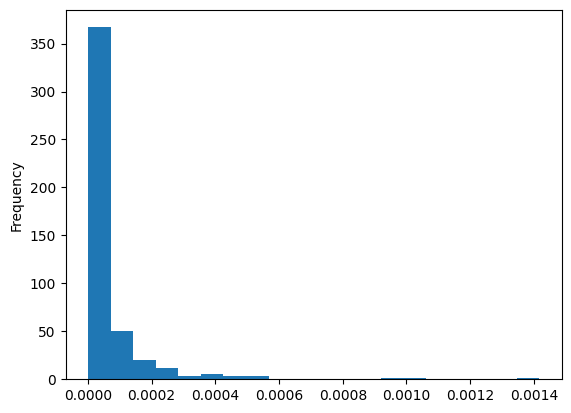

In [65]:
county_hate_rates_df["hate_crime_rate"].plot.hist(bins=20)

####Transform hate_rate data to a Gaussian distribution

In [66]:
hate_features = ["hate_crime_count", "hate_crime_rate"]
# save the hate feature data for adding back later
hate_crime_rates_df = county_hate_rates_df[hate_features]

# transform the hate_crime_rate data
transform_standardize_data(county_hate_rates_df, hate_features, [])
county_hate_rates_df = pd.concat([county_hate_rates_df, hate_crime_rates_df], axis=1, join="outer")

hate_rate_numerical_cols = [col for col in county_hate_rates_df.select_dtypes(include=["int64", "float64"]).columns if (("transformed" in col)\
                                                                                                                        or (col in hate_features))]

county_hate_rates_df = county_hate_rates_df[hate_rate_numerical_cols]

Performing quantile transformation process...
Renaming numerical columns...
Dropping categorical columns with insufficient sample size...


<Axes: ylabel='Frequency'>

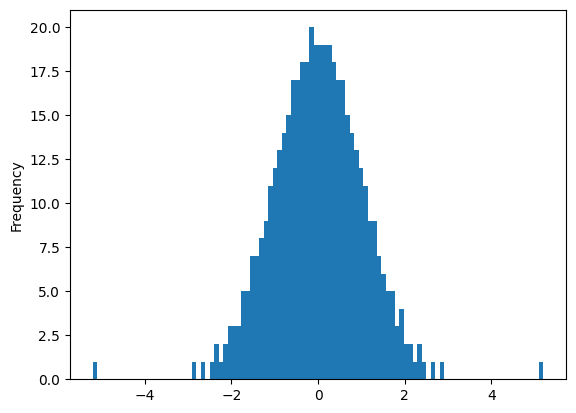

In [67]:
county_hate_rates_df['transformed_hate_crime_rate'].plot.hist(bins=100)

##Merge the datasets

In [68]:
# combine the crime and population datasets
merged_df = pd.merge(crime_df, county_demo_df, on=["pug_agency_name", "agency_type_name", "state_name"])

In [69]:
merged_df.drop(other_unique_categorical_cols["pug_agency_name"] + ["ori", "state_abbr", "population_group_code", "pub_agency_unit",
                "Geography", "Percent!!Total population", "population_group_description",
                "Geographic Area Name", "incident_date", "pub_agency_unit", "pug_agency_name",
                "agency_type_name", "state_name", "division_name", "offender_race", "offender_ethnicity",
                "location_name", "bias_desc", "victim_types", "multiple_offense",
                  "multiple_bias"], axis=1, inplace=True)

#Data Exploration

##Important Functions

In [70]:
def get_sorted_corrs(corr):
  # Unstack and rename corr
  corr_sorted = pd.DataFrame(corr.unstack()).reset_index()
  corr_sorted.rename(columns={"level_0":"feature1", "level_1":"feature2", 0:"corr"}, inplace=True)

  corr_sorted["abs_corr"] = 0

  # Get highest correlation coefficient pairs
  corr_sorted["abs_corr"] = corr_sorted["corr"].abs()
  corr_sorted.sort_values(by="abs_corr", ascending=False, inplace=True)

  #reset the indices
  corr_sorted.reset_index(inplace=True)

  #filter out self-correlations
  corr_sorted = corr_sorted[~(corr_sorted["feature1"] == corr_sorted["feature2"])]

  # remove duplicates
  # only keep even-numbered rows, since there will be 2 of every correlation
  corr_sorted = corr_sorted.iloc[::2]
  # corr_sorted = corr_sorted.dropna().groupby("feature1")

  return corr_sorted

In [71]:
def do_corr_analysis(corr, minThreshold, maxThreshold, blacklistPhraseRegex, corr_sorted=None):
    # get the sorted correlation coefficients
    if corr_sorted is None:
      sorted_corrs = get_sorted_corrs(crime_corr)
    else:
      sorted_corrs = corr_sorted

    # create subplot display
    fig, ax = plt.subplots(3, figsize=(10, 20))

    # plot stuff
    sorted_corrs["corr"].plot.hist(bins=40, logy=True, ax=ax[0], title="Correlation Coefficients")
    sorted_corrs["abs_corr"].plot.hist(bins=40, logy=True, ax=ax[1], title="Correlation Coefficients' Absolute Values")

    # filter down to correlations of interest
    corrs_of_interest = sorted_corrs[(sorted_corrs["abs_corr"] > minThreshold) & (sorted_corrs["abs_corr"] < maxThreshold)
                                      & (~sorted_corrs["feature1"].str.contains(blacklistPhraseRegex))
                                      & (~sorted_corrs["feature2"].str.contains(blacklistPhraseRegex))]

    # plot the remaining correlations
    corrs_of_interest["corr"].plot.hist(bins=50, logy=True, ax=ax[2], title="Correlation Coefficients of Interest")

    return sorted_corrs, corrs_of_interest

##Individual Datasets

###Hate Crime Dataset

In [72]:
crime_df.head()

level_0   index  incident_id  data_year        ori pug_agency_name  \
0        0  209205      1401052       2020  AL0650000      Washington   
1        1  209206      1403751       2020  AL0270000          Dallas   
2        2  209210      1455329       2020  AL0240000        Crenshaw   
3        3  209211      1455330       2020  AL0280000          DeKalb   
4        4  209213      1455332       2020  AL0650000      Washington   

  pub_agency_unit agency_type_name state_abbr state_name       division_name  \
0             NaN           County         AL    Alabama  East South Central   
1             NaN           County         AL    Alabama  East South Central   
2             NaN           County         AL    Alabama  East South Central   
3             NaN           County         AL    Alabama  East South Central   
4             NaN           County         AL    Alabama  East South Central   

  region_name population_group_code              population_group_description  \
0       South                    9C      MSA counties from 10,000 thru 24,999   
1       South                    8C  Non-MSA counties from 10,000 thru 24,999   
2       South                    8D             Non-MSA counties under 10,000   
3       South                    8B  Non-MSA counties from 25,000 thru 99,999   
4       South                    9C      MSA counties from 10,000 thru 24,999   

  incident_date  adult_victim_count  juvenile_victim_count  \
0    2020-02-08                 0.0                    0.0   
1    2020-03-17                 0.0                    0.0   
2    2020-01-18                 1.0                    0.0   
3    2020-05-04                 1.0                    0.0   
4    2020-03-16                 0.0                    0.0   

   total_offender_count  adult_offender_count  juvenile_offender_count  \
0                     2                   2.0                      0.0   
1                     4                   3.0                      1.0   
2                     1                   1.0                      0.0   
3                     1                   1.0                      0.0   
4                     1                   1.0                      0.0   

  offender_race      offender_ethnicity  victim_count  \
0         White  Not Hispanic or Latino             2   
1       Unknown           Not Specified             1   
2         White  Not Hispanic or Latino             1   
3         White           Not Specified             1   
4         White  Not Hispanic or Latino             1   

                                        offense_name  \
0  Drug Equipment Violations;Drug/Narcotic Violat...   
1                          Drug Equipment Violations   
2                       Burglary/Breaking & Entering   
3                                     Simple Assault   
4                          Drug Equipment Violations   

   total_individual_victims                                  location_name  \
0                       0.0             Highway/Road/Alley/Street/Sidewalk   
1                       0.0  Jail/Prison/Penitentiary/Corrections Facility   
2                       1.0                                 Residence/Home   
3                       1.0                                 Residence/Home   
4                       0.0             Highway/Road/Alley/Street/Sidewalk   

    bias_desc    victim_types multiple_offense multiple_bias  incident_month  \
0  Anti-White  Society/Public                M             S               2   
1  Anti-White  Society/Public                S             S               3   
2  Anti-White      Individual                S             S               1   
3  Anti-White      Individual                S             S               5   
4  Anti-White  Society/Public                S             S               3   

   incident_day  bias_desc_Anti-American Indian or Alaska Native  \
0             8                                                0   
1           

####Correlation matrix

In [73]:
for item in ['level_0', 'index', 'incident_id', 'data_year']:
  if item in crime_numerical_cols:
    crime_numerical_cols.remove(item)

In [74]:
# Create a correlation matrix
crime_corr = crime_df[crime_numerical_cols].dropna().corr()

In [75]:
# # Set the figure size
# plt.figure(figsize=(200, 100))

# # Create a heatmap of the correlation matrix
# sns.heatmap(crime_corr, annot=True)

# # Show the plot
# plt.show()

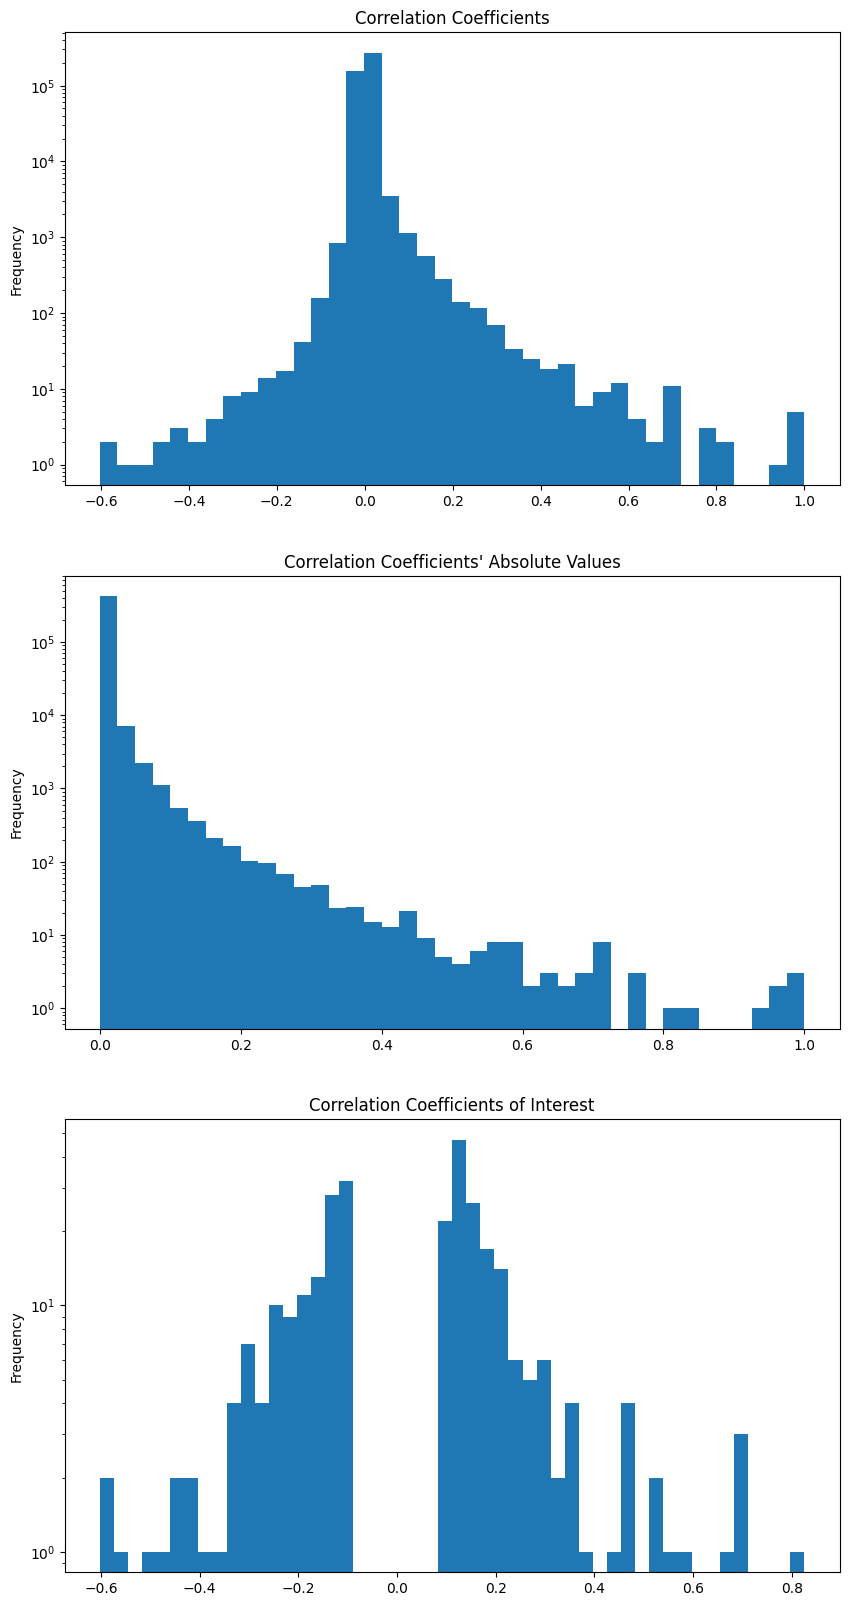

In [76]:
sorted_crime_corrs, crime_corrs_of_interest = do_corr_analysis(crime_corr, 0.1, 1, "pug_agency_name|state_name")

In [77]:
crime_corrs_of_interest

index                                           feature1  \
942      6114                           total_individual_victims   
954     49992                        victim_types_Society/Public   
962     94817        location_name_Abandoned/Condemned Structure   
968    102967       location_name_Church/Synagogue/Temple/Mosque   
974      5101                                       victim_count   
986     45904                            victim_types_Individual   
988    981245            offender_race_Black or African American   
992      6159                           total_individual_victims   
1014   991438                         offender_ethnicity_Unknown   
1018     5095                                       victim_count   
1030     3059                               adult_offender_count   
1034    61189             offense_name_Drug Equipment Violations   
1036   986339                                offender_race_White   
1052     6112                                       victim_count   
1054     4077                            juvenile_offender_count   
1056    91759                 offense_name_Weapon Law Violations   
1062    62204              offense_name_Drug/Narcotic Violations   
1066       45                                 adult_victim_count   
1070   989401          offender_ethnicity_Not Hispanic or Latino   
1094     3061                               adult_offender_count   
1104     4206                            juvenile_offender_count   
1112    49937                        victim_types_Society/Public   
1134    43862                              victim_types_Business   
1138        1                                 adult_victim_count   
1170    72432                          offense_name_Intimidation   
1174   132471          location_name_School-Elementary/Secondary   
1182   987413                        offender_ethnicity_Multiple   
1184     3001                               total_offender_count   
1196     2042                               total_offender_count   
1212    48947                victim_types_Religious Organization   
1220    49931                        victim_types_Society/Public   
1232   985324                              offender_race_Unknown   
1234    61185             offense_name_Drug Equipment Violations   
1260     6175                           total_individual_victims   
1262   991434                         offender_ethnicity_Unknown   
1314    96831                       location_name_Amusement Park   
1322    46919               victim_types_Law Enforcement Officer   
1326   118330   location_name_Highway/Road/Alley/Street/Sidewalk   
1334     3187                               adult_offender_count   
1362    97850   location_name_Arena/Stadium/Fairgrounds/Coliseum   
1370   975121                              division_name_Pacific   
1372     6157                           total_individual_victims   
1374   990421                   offender_ethnicity_Not Specified   
1380    45899                            victim_types_Individual   
1382    50047                        victim_types_Society/Public   
1384   102954       location_name_Church/Synagogue/Temple/Mosque   
1386    43899                              victim_types_Business   
1400   102931       location_name_Church/Synagogue/Temple/Mosque   
1402    99919                location_name_Bank/Savings and Loan   
1410    14308           bias_desc_Anti-Black or African American   
1420    44895                            victim_types_Government   
1422        4                                 adult_victim_count   
1430    10303                                bias_desc_Anti-Arab   
1448        3                                 adult_victim_count   
1474    62275              offense_name_Drug/Narcotic Violations   
1520    79531          offense_name_Pornography/Obscene Material   
1522      130                                 adult_victim_count   
1524       61                                 adult_victim_count

####Quantitative variable figures

<Axes: title={'center': 'total_offender_count'}, ylabel='Frequency'>

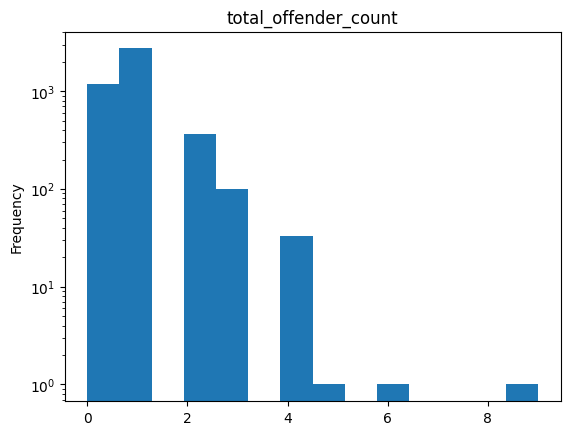

In [78]:
crime_df['total_offender_count'].plot.hist(bins=14, title='total_offender_count', logy=True)

<Axes: title={'center': 'adult_victim_count'}, ylabel='Frequency'>

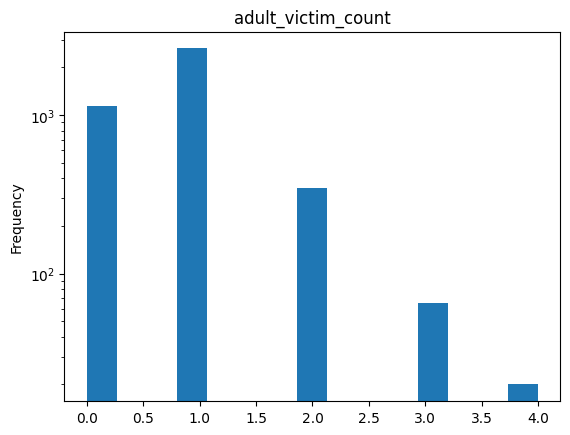

In [79]:
crime_df['adult_victim_count'].plot.hist(bins=15, title='adult_victim_count', logy=True)

<Axes: title={'center': 'juvenile_victim_count'}, ylabel='Frequency'>

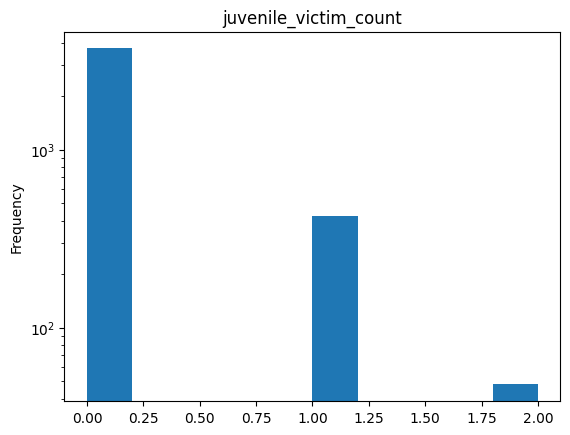

In [80]:
crime_df['juvenile_victim_count'].plot.hist(bins=10, title='juvenile_victim_count', logy=True)

####Categorical variable figures


In [81]:
def plot_column_counts(df, column_name, unique_values, title_phrase, figsize=(20, 5), rotation=90):
    # Create a dictionary of unique values and their counts
    unique_value_counts = get_col_counts(df, unique_values)

    # Sort the dictionary by values in descending order
    sorted_value_counts = dict(sorted(unique_value_counts.items(), key=lambda item: item[1], reverse=True))

    # Create a bar chart of the sorted valuees and their counts
    plt.figure(figsize=figsize)
    sns.barplot(x=list(sorted_value_counts.keys()), y=list(sorted_value_counts.values()), log=True)

    # Set the title and labels
    plt.title("Frequency of " + title_phrase + " in Hate Crimes", fontsize=16)
    plt.xlabel(title_phrase, fontsize=14)
    plt.ylabel("Frequency (Log Scale)", fontsize=14)

    # Rotate the x-axis labels for readability
    plt.xticks(rotation=rotation)

    # Show the plot
    plt.show()


(array([0, 1, 2, 3]),
 [Text(0, 0, 'South'),
  Text(1, 0, 'West'),
  Text(2, 0, 'Midwest'),
  Text(3, 0, 'Northeast')])

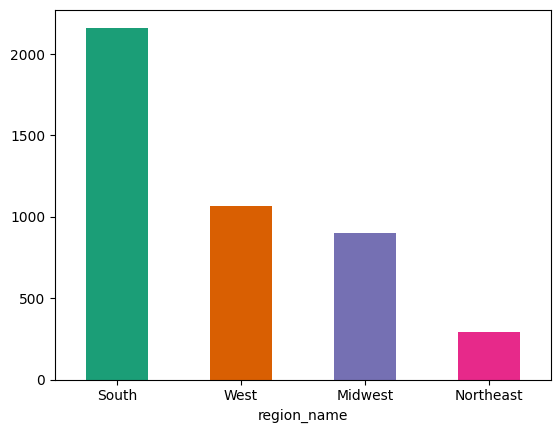

In [82]:
crime_df.groupby('region_name').size().sort_values(ascending=False).plot.bar(color=sns.palettes.mpl_palette('Dark2'))
plt.xticks(rotation=0)

<Axes: ylabel='offender_race'>

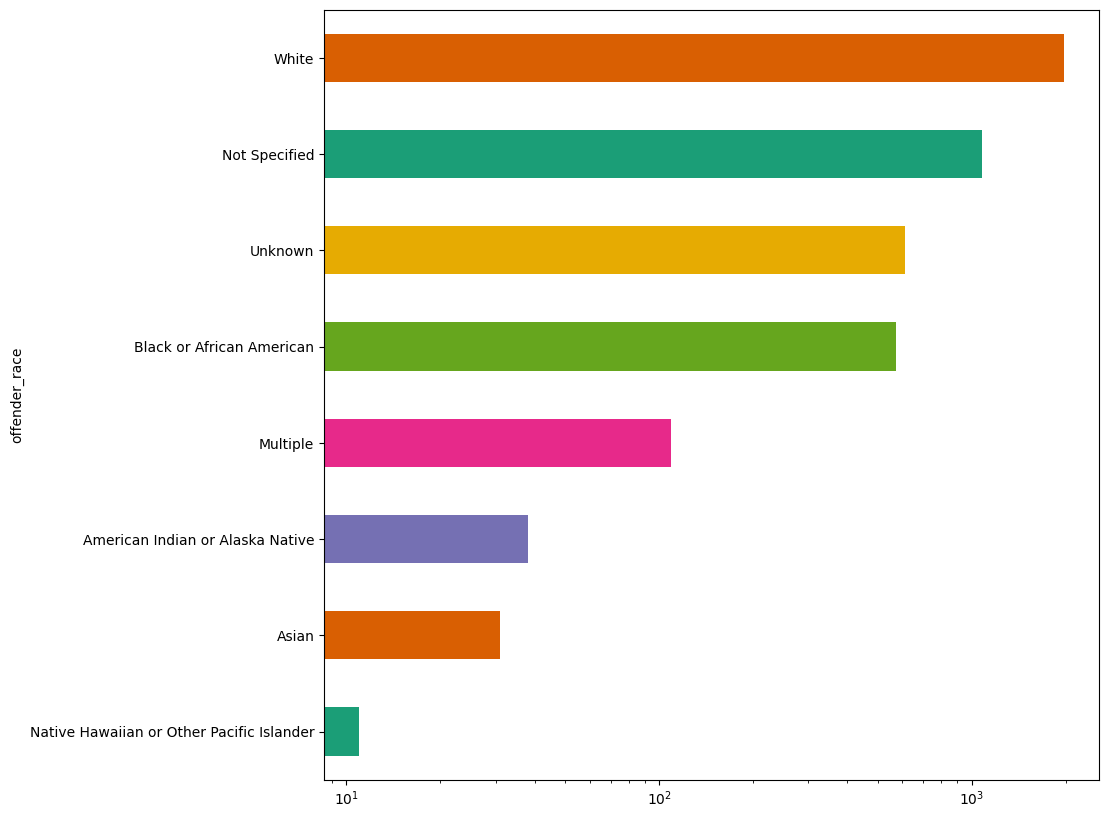

In [83]:
crime_df.groupby('offender_race').size().sort_values(ascending=True).plot.barh(color=sns.palettes.mpl_palette('Dark2'), figsize=(10,10), logx=True)

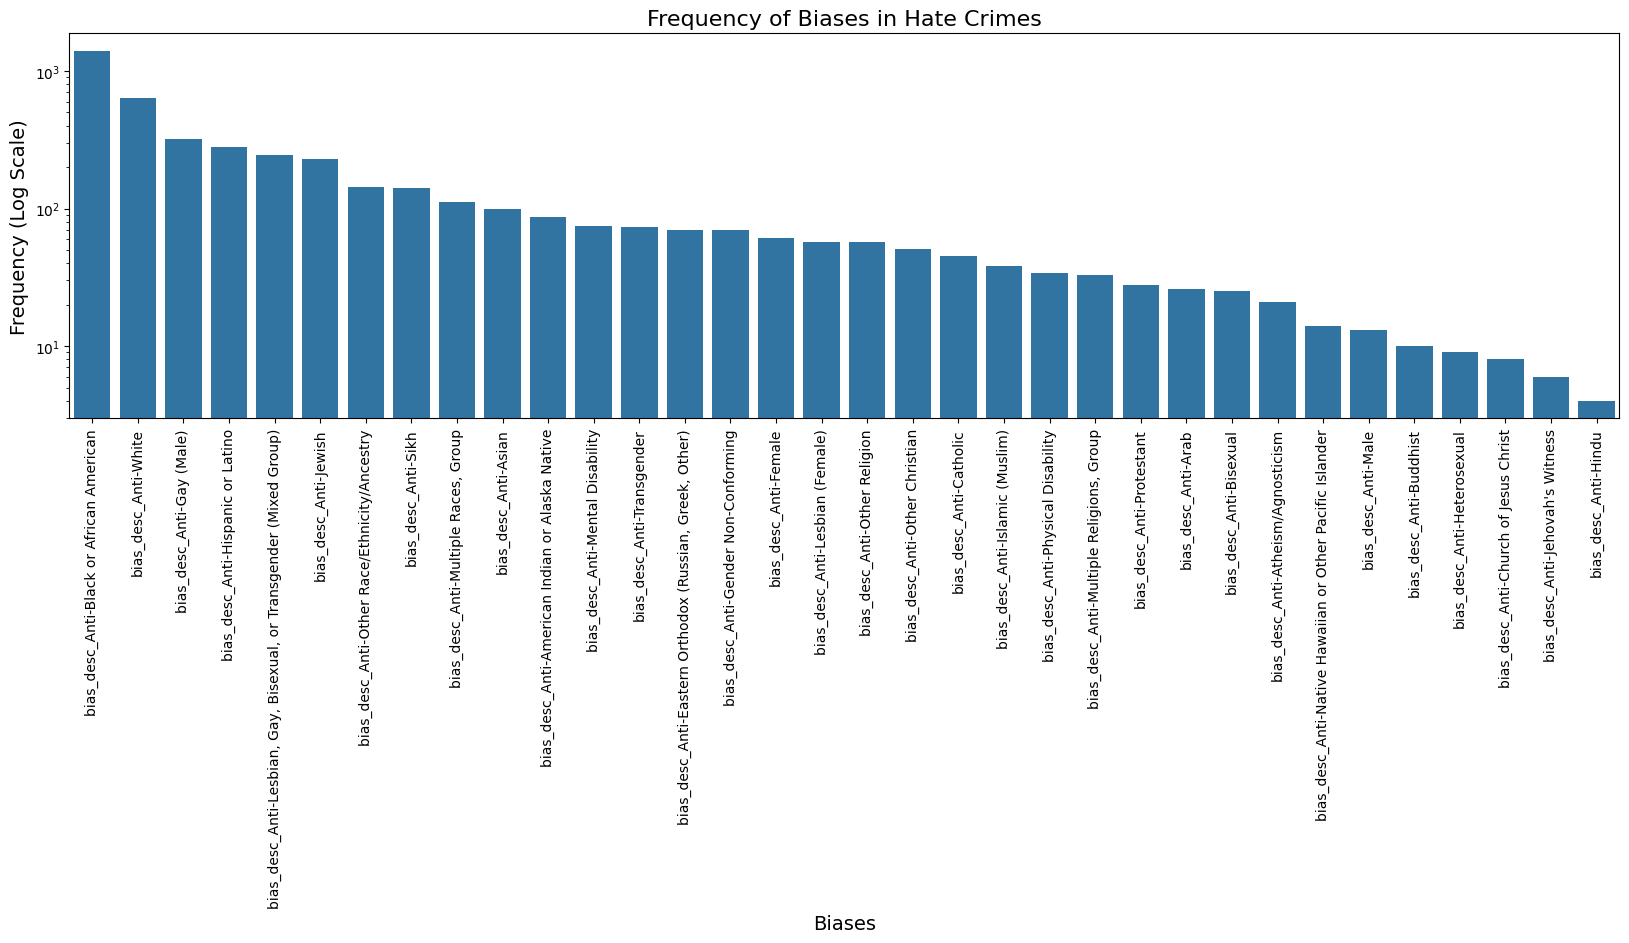

In [84]:
plot_column_counts(crime_df, "bias_desc", bias_cols, "Biases")

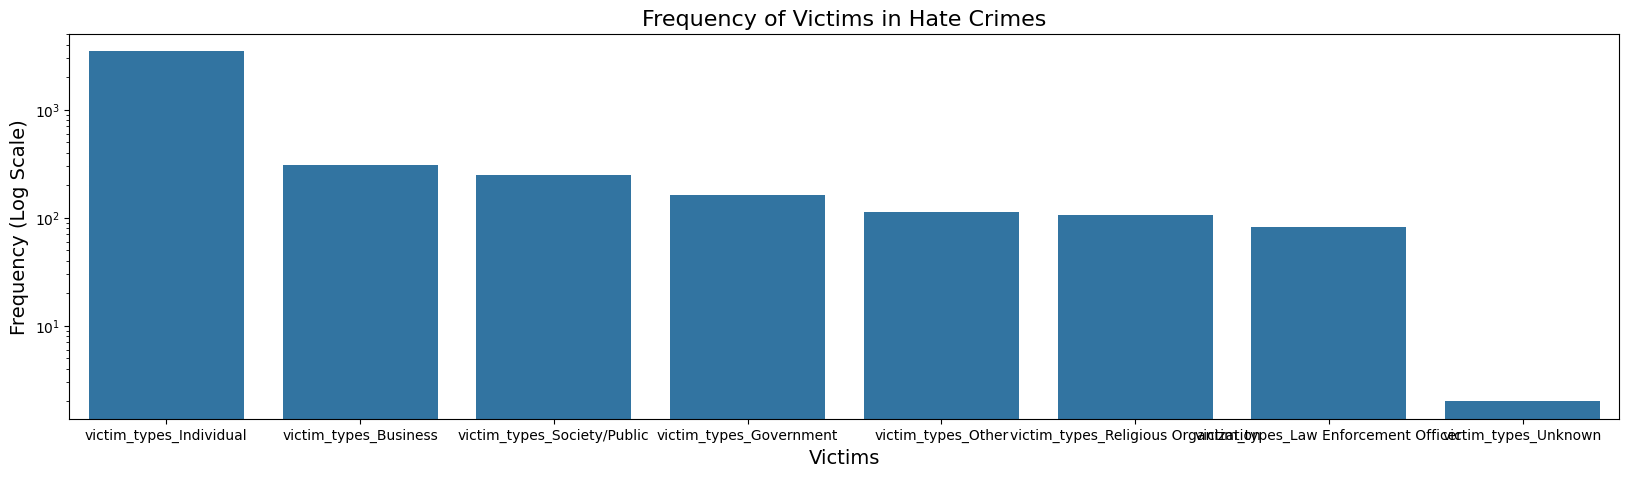

In [85]:
figsize=(20, 5)
plot_column_counts(crime_df, "victim_types", victim_cols, "Victims", figsize, 0)

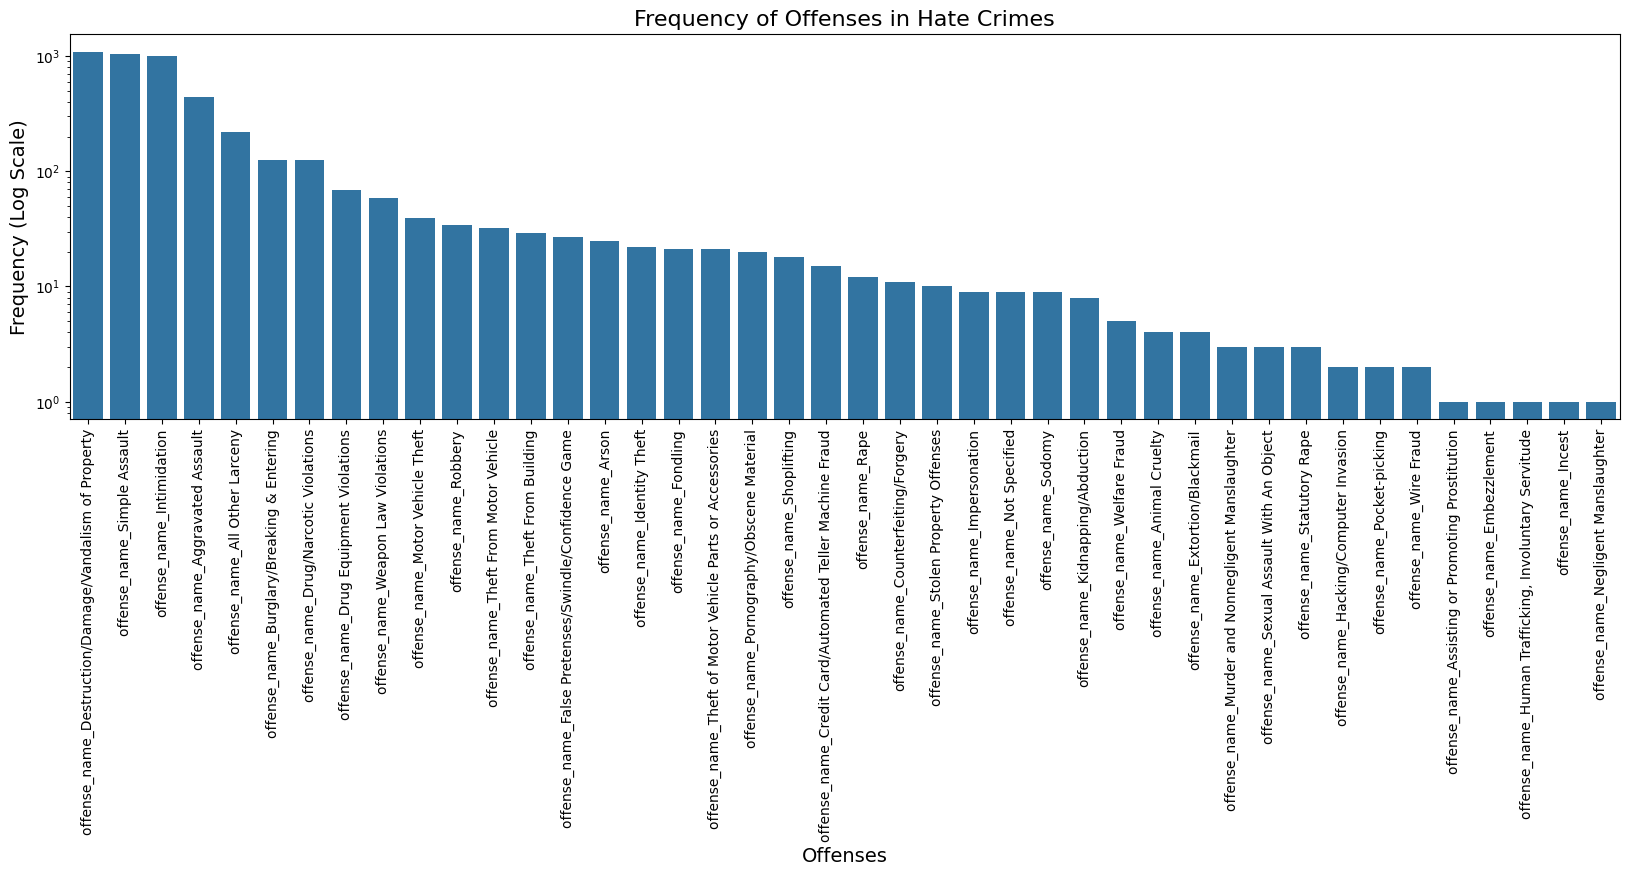

In [86]:
plot_column_counts(crime_df, "offense_name", offense_cols, "Offenses")

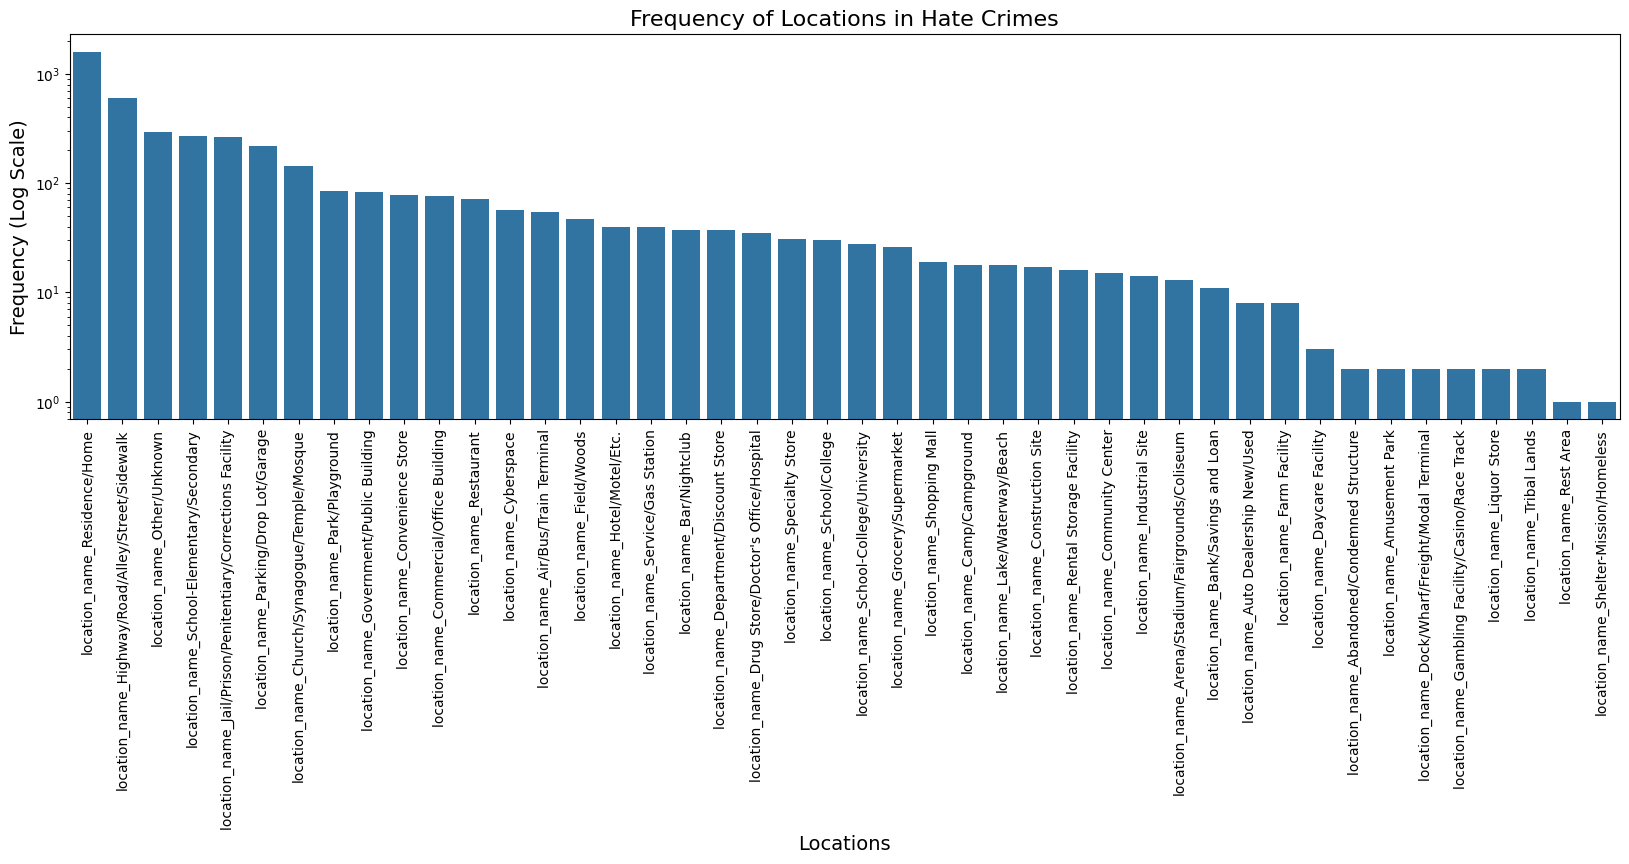

In [87]:
plot_column_counts(crime_df, "location_names", location_cols, "Locations")

####Geographic heat maps

In [88]:
ignore_list = ["Not Specified", "Unknown", "Multiple"]

Text(70.7222222222222, 0.5, 'Offender Race')

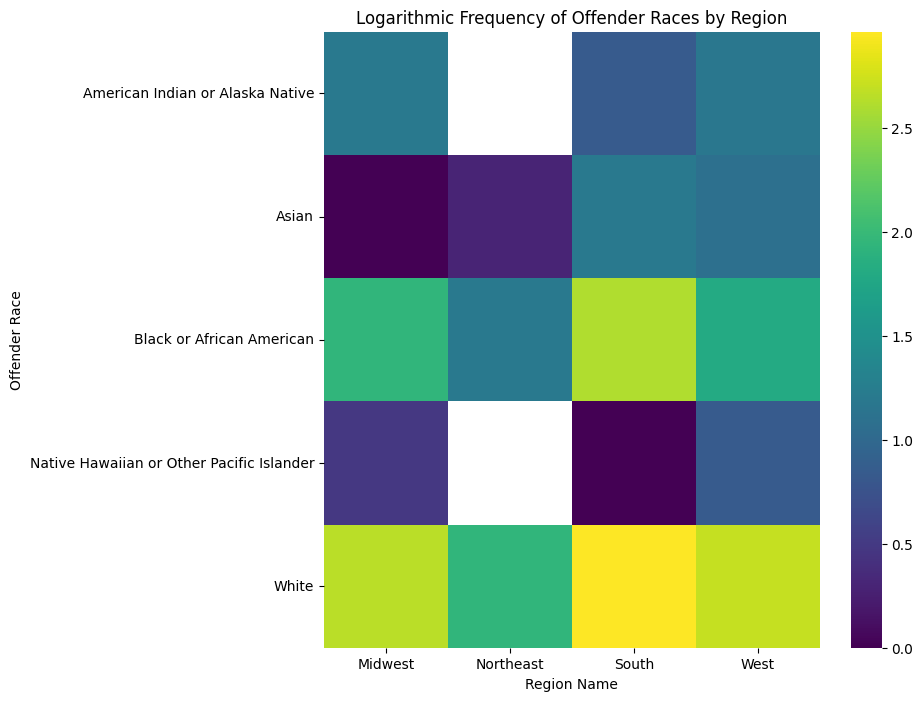

In [89]:
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['offender_race'].value_counts()
    for x_label, grp in crime_df.groupby('region_name')
})

# Drop less relevant columns for easier comparison with victim race heatmap
for item in ignore_list:
  df_2dhist.drop(item, inplace=True)

# Apply logarithmic transformation to the counts
df_2dhist_log = df_2dhist.applymap(lambda x: 0 if x == 0 else np.log10(x))

sns.heatmap(df_2dhist_log, cmap='viridis')
plt.title("Logarithmic Frequency of Offender Races by Region")
plt.xlabel("Region Name")
plt.ylabel("Offender Race")

In [90]:
# Get some victim races to start with
unique_offender_races = crime_df['offender_race'].unique().tolist()

# Drop categories absent from victim data
for item in ignore_list:
  unique_offender_races.remove(item)

unique_victim_races = ["bias_desc_Anti-" + str(race) for race in unique_offender_races]

print(unique_victim_races)

['bias_desc_Anti-White', 'bias_desc_Anti-Black or African American', 'bias_desc_Anti-American Indian or Alaska Native', 'bias_desc_Anti-Asian', 'bias_desc_Anti-Native Hawaiian or Other Pacific Islander']


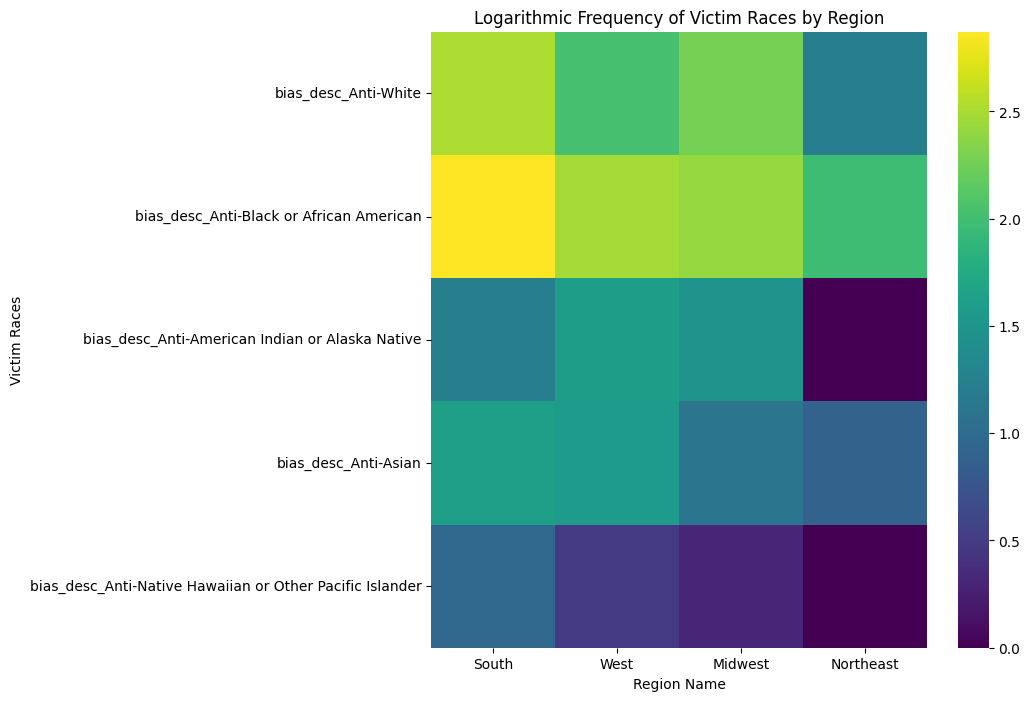

In [91]:
plt.subplots(figsize=(8, 8))

# Initialize an empty DataFrame with the correct index and columns
df_2dhist = pd.DataFrame(index=unique_victim_races, columns=crime_df['region_name'].unique())

# Iterate over each region and calculate the value counts for each victim race
for region in df_2dhist.columns:
    region_data = crime_df[crime_df['region_name'] == region]

    for victim_race in unique_victim_races:
        # Sum of occurrences of victim_race in the region
        count = region_data[victim_race].sum()
        # Update the DataFrame cell with the count
        df_2dhist.loc[victim_race, region] = count

# Convert DataFrame entries to numeric type and drop nan values
df_2dhist = df_2dhist.apply(pd.to_numeric)

# Apply logarithmic transformation to the counts
df_2dhist = df_2dhist.applymap(lambda x: 0 if x == 0 else np.log10(x))

# Create the heatmap with logarithmic scale
sns.heatmap(df_2dhist, cmap='viridis')

# Give the plot a title and axis labels
plt.title("Logarithmic Frequency of Victim Races by Region")
plt.xlabel("Region Name")
plt.ylabel("Victim Races")
plt.yticks(rotation=0)

plt.show()

###County Demographics Dataset

In [92]:
county_demo_df.head()

Geography     Geographic Area Name  Total population    Male  Female  \
1  0500000US01003  Baldwin County, Alabama            246435  120664  125771   
2  0500000US01015  Calhoun County, Alabama            115788   56554   59234   
3  0500000US01043  Cullman County, Alabama             90665   45051   45614   
4  0500000US01049   DeKalb County, Alabama             71998   36024   35974   
5  0500000US01051   Elmore County, Alabama             89563   43448   46115   

   Sex ratio (males per 100 females)  Under 5 years  5 to 9 years  \
1                               95.9          12553         15581   
2                               95.5           6661          5376   
3                               98.8           5449          5785   
4                              100.1           4031          5086   
5                               94.2           4519          4559   

   10 to 14 years  15 to 19 years  20 to 24 years  25 to 34 years  \
1           13705           13772           12065           28027   
2            7505            8145            9623           14606   
3            5204            5545            5209           11930   
4            4491            5322            4693            8029   
5            6623            5093            4907           13068   

   35 to 44 years  45 to 54 years  55 to 59 years  60 to 64 years  \
1           29375           32326           14586           20499   
2           13115           14388            7346            7578   
3           10752           11341            5870            6204   
4            9479            8707            4628            4769   
5           12284           11601            5818            6497   

   65 to 74 years  75 to 84 years  85 years and over  Median age (years)  \
1           31594           16612               5740                44.5   
2           13217            6723               1505                39.4   
3           10047            5680               1649                40.7   
4            7604            4384                775                39.6   
5            8936            5053                605                38.8   

   Under 18 years  16 years and over  21 years and over  62 years and over  \
1         51269.0           201504.0           188973.0            66568.0   
2         24410.0            94762.0            84925.0            25918.0   
3         20170.0            72822.0            67293.0            20874.0   
4         17043.0            56340.0            51821.0            16141.0   
5         18970.0            72804.0            67760.0            18339.0   

   18 years and over  18 years and over!!Male  18 years and over!!Female  \
1           195166.0                  94150.0                   101016.0   
2            91378.0                  43693.0                    47685.0   
3            70495.0                  34385.0                    36110.0   
4            54955.0                  27072.0                    27883.0   
5            70593.0                  33813.0                    36780.0   

   18 years and over!!Sex ratio (males per 100 females)  65 years and over  \
1                                               93.2               53946.0   
2                                               91.6               21445.0   
3                                               95.2               17376.0   
4                                               97.1               12763.0   
5                                               91.9               14594.0   

   65 years and over!!Male  65 years and over!!Female  \
1                  24683.0                    29263.0   
2                   9214.0                    12231.0   
3                   7729.0                     9647.0   
4                   5788.0                     6975.0   
5                   6410.0                     8184.0   

   65 years and over!!Sex ratio (males per 100 females)  \
1                           

####Correlation matrix

In [93]:
county_numerical_cols = list(county_demo_df.select_dtypes(include=["int64", "float64"]).columns)

In [94]:
# Create a correlation matrix
county_corr = county_demo_df[county_numerical_cols].corr()

In [95]:
# # Set the figure size
# plt.figure(figsize=(100, 50))

# # Create a heatmap of the correlation matrix
# sns.heatmap(county_corr, annot=True)

# # Show the plot
# plt.show()

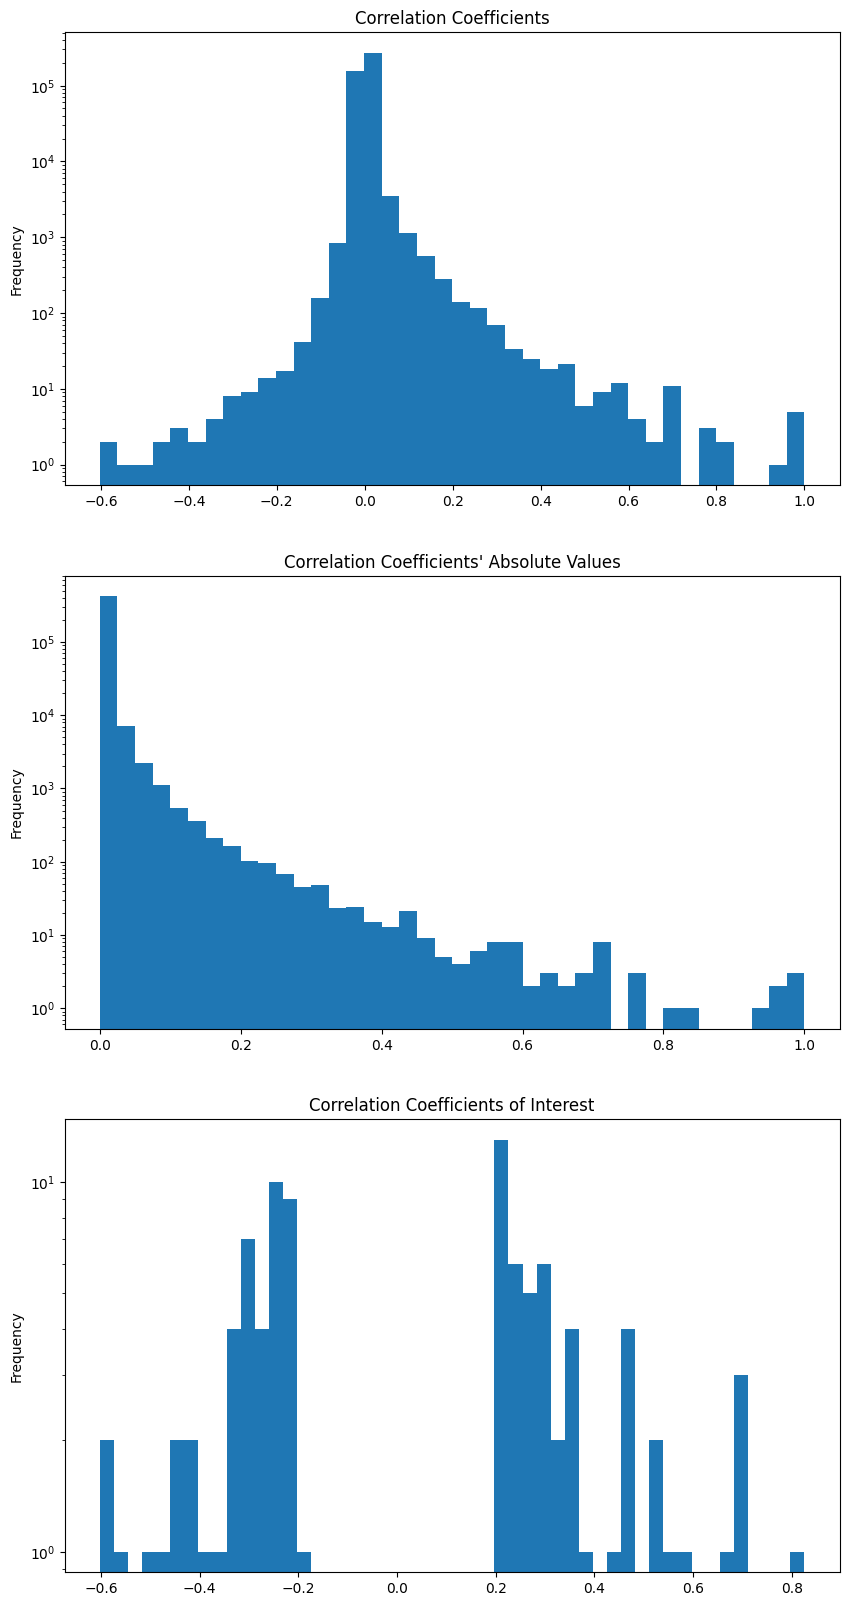

In [96]:
sorted_county_corrs, county_corrs_of_interest = do_corr_analysis(county_corr, 0.2, 0.9, "pug_agency_name|state_name")

In [97]:
county_corrs_of_interest

index                                           feature1  \
942      6114                           total_individual_victims   
954     49992                        victim_types_Society/Public   
962     94817        location_name_Abandoned/Condemned Structure   
968    102967       location_name_Church/Synagogue/Temple/Mosque   
974      5101                                       victim_count   
986     45904                            victim_types_Individual   
988    981245            offender_race_Black or African American   
992      6159                           total_individual_victims   
1014   991438                         offender_ethnicity_Unknown   
1018     5095                                       victim_count   
1030     3059                               adult_offender_count   
1034    61189             offense_name_Drug Equipment Violations   
1036   986339                                offender_race_White   
1052     6112                                       victim_count   
1054     4077                            juvenile_offender_count   
1056    91759                 offense_name_Weapon Law Violations   
1062    62204              offense_name_Drug/Narcotic Violations   
1066       45                                 adult_victim_count   
1070   989401          offender_ethnicity_Not Hispanic or Latino   
1094     3061                               adult_offender_count   
1104     4206                            juvenile_offender_count   
1112    49937                        victim_types_Society/Public   
1134    43862                              victim_types_Business   
1138        1                                 adult_victim_count   
1170    72432                          offense_name_Intimidation   
1174   132471          location_name_School-Elementary/Secondary   
1182   987413                        offender_ethnicity_Multiple   
1184     3001                               total_offender_count   
1196     2042                               total_offender_count   
1212    48947                victim_types_Religious Organization   
1220    49931                        victim_types_Society/Public   
1232   985324                              offender_race_Unknown   
1234    61185             offense_name_Drug Equipment Violations   
1260     6175                           total_individual_victims   
1262   991434                         offender_ethnicity_Unknown   
1314    96831                       location_name_Amusement Park   
1322    46919               victim_types_Law Enforcement Officer   
1326   118330   location_name_Highway/Road/Alley/Street/Sidewalk   
1334     3187                               adult_offender_count   
1362    97850   location_name_Arena/Stadium/Fairgrounds/Coliseum   
1370   975121                              division_name_Pacific   
1372     6157                           total_individual_victims   
1374   990421                   offender_ethnicity_Not Specified   
1380    45899                            victim_types_Individual   
1382    50047                        victim_types_Society/Public   
1384   102954       location_name_Church/Synagogue/Temple/Mosque   
1386    43899                              victim_types_Business   
1400   102931       location_name_Church/Synagogue/Temple/Mosque   
1402    99919                location_name_Bank/Savings and Loan   
1410    14308           bias_desc_Anti-Black or African American   
1420    44895                            victim_types_Government   
1422        4                                 adult_victim_count   
1430    10303                                bias_desc_Anti-Arab   
1448        3                                 adult_victim_count   
1474    62275              offense_name_Drug/Narcotic Violations   
1520    79531          offense_name_Pornography/Obscene Material   
1522      130                                 adult_victim_count   
1524       61                                 adult_victim_count

####Other figures

<Axes: xlabel='Under 5 years', ylabel='85 years and over'>

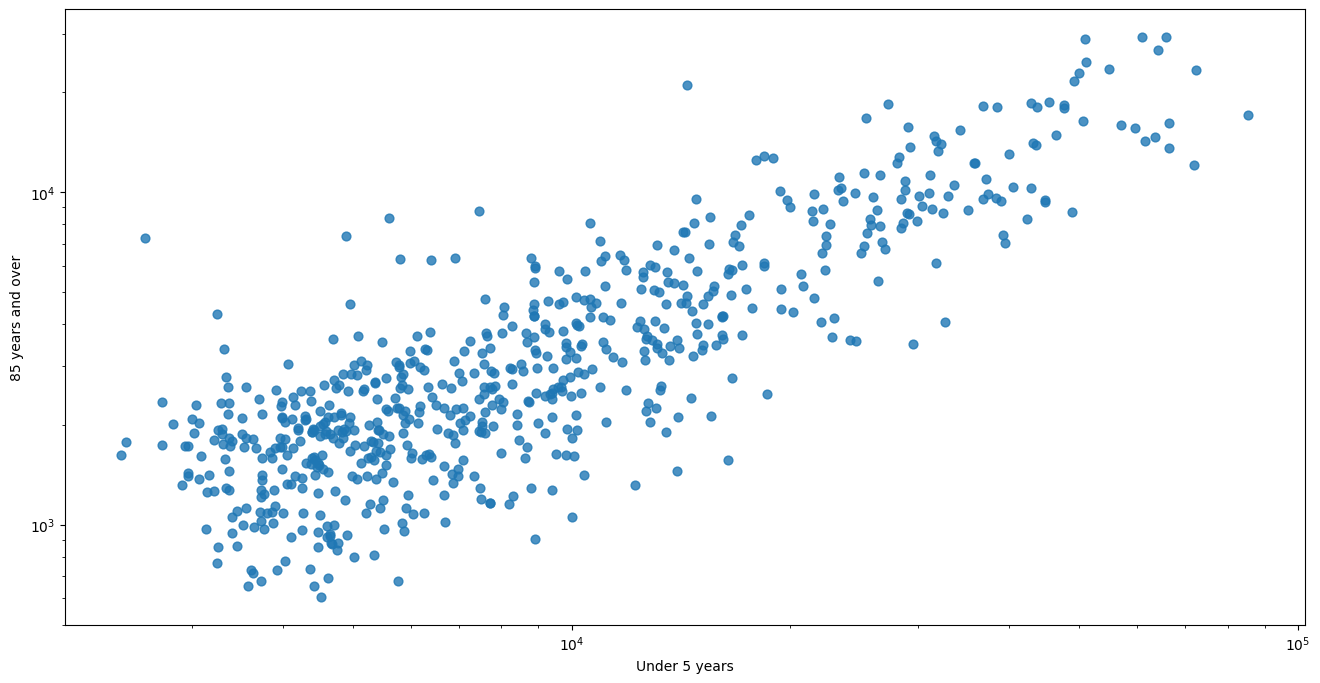

In [98]:
county_demo_df.plot.scatter(x='Under 5 years', y='85 years and over', logx=True, logy=True, s=40, alpha=.8, figsize=(16,8))

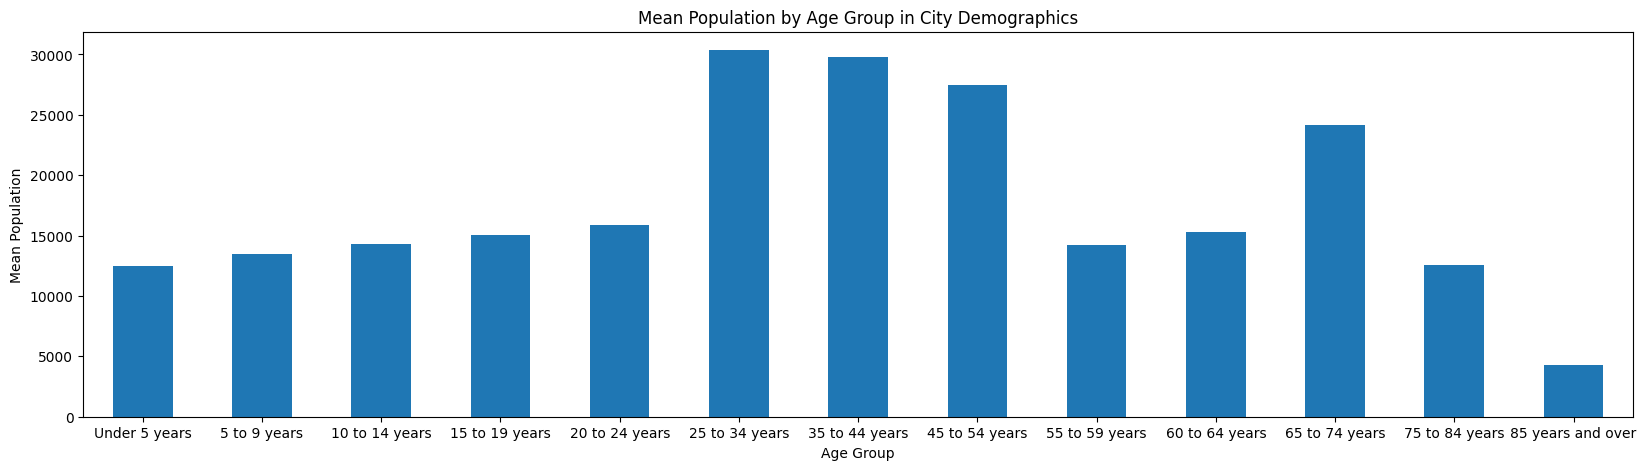

In [99]:
county_demo_df[age_groups].mean().plot.bar(figsize=(20,5))
plt.xlabel('Age Group')
plt.ylabel('Mean Population')
plt.title('Mean Population by Age Group in City Demographics')
plt.xticks(rotation=0)
plt.show()

##Merged Datasets

###Primary Merged Dataset

In [100]:
merged_df.head()

level_0   index  incident_id  data_year region_name  adult_victim_count  \
0        3  209211      1455330       2020       South                 1.0   
1        8  209218      1455338       2020       South                 1.0   
2        9  209219      1455339       2020       South                 1.0   
3       14  209242      1455639       2020       South                 0.0   
4       21  209466      1253831       2020        West                 NaN   

   juvenile_victim_count  total_offender_count  adult_offender_count  \
0                    0.0                     1                   1.0   
1                    0.0                     0                   NaN   
2                    0.0                     1                   1.0   
3                    0.0                     0                   NaN   
4                    NaN                     0                   0.0   

   juvenile_offender_count  victim_count  \
0                      0.0             1   
1                      NaN             1   
2                      0.0             1   
3                      NaN             1   
4                      0.0             1   

                               offense_name  total_individual_victims  \
0                            Simple Assault                       1.0   
1  Destruction/Damage/Vandalism of Property                       1.0   
2                        Aggravated Assault                       1.0   
3  Destruction/Damage/Vandalism of Property                       0.0   
4                                     Arson                       NaN   

   incident_month  incident_day  \
0               5             4   
1               2             4   
2               2            11   
3               6            28   
4               2            18   

   bias_desc_Anti-American Indian or Alaska Native  bias_desc_Anti-Arab  \
0                                                0                    0   
1                                                0                    0   
2                                                0                    0   
3                                                0                    0   
4                                                0                    0   

   bias_desc_Anti-Asian  bias_desc_Anti-Atheism/Agnosticism  \
0                     0                                   0   
1                     0                                   0   
2                     0                                   0   
3                     0                                   0   
4                     0                                   0   

   bias_desc_Anti-Bisexual  bias_desc_Anti-Black or African American  \
0                        0                                         0   
1                        0                                         1   
2                        0                                         0   
3                        0                                         0   
4                        0                                         0   

   bias_desc_Anti-Buddhist  bias_desc_Anti-Catholic  \
0                        0                        0   
1                        0                        0   
2                        0                        0   
3                        0                        0   
4                        0                        0   

   bias_desc_Anti-Church of Jesus Christ  \
0                                      0   
1                                      0   
2                                      0   
3                                      0   
4                                      0   

   bias_desc_Anti-Eastern Orthodox (Russian, Greek, Other)  \
0                                                  0         
1                                                  0         
2                                                  0         
3                                                  0         
4                

####Correlation Matrix Analysis

In [101]:
#convert the categorical columns to numerical ones and store the modified df as a new df for correlation analysis
categorical_to_int_df = merged_df\
                          .select_dtypes(include=['int64', 'float64', np.number])\
                          .drop(labels=["index", "incident_id"], axis=1)
# Select only the numerical columns
numerical_cols = [col for col in categorical_to_int_df.columns if "transformed_" in col]
# numerical_cols

In [102]:
# Create a correlation matrix
merged_corr = merged_df[numerical_cols].corr()

In [103]:
merged_corr_sorted = get_sorted_corrs(merged_corr)
merged_corr_sorted.head()

index                               feature1  \
1    5147  transformed_Percent!!Total population   
8    4615          transformed_65 years and over   
14   5110  transformed_Percent!!Total population   
30      1                    transformed_level_0   
47   1666           transformed_Total population   

                                             feature2  corr  abs_corr  
1   transformed_Percent!!HISPANIC OR LATINO AND RA...   1.0       1.0  
8              transformed_Percent!!65 years and over   1.0       1.0  
14        transformed_Percent!!RACE!!Total population   1.0       1.0  
30                                  transformed_index   1.0       1.0  
47        transformed_Percent!!RACE!!Total population   1.0       1.0

In [104]:
# remove coefficients that represent variables' correlations with themselves
#   and remove feature correlations with other features from the same set (which were reviewed in the individual dataset explorations above)
county_cols = list(county_numerical_cols)
crime_cols = list(crime_numerical_cols)

merged_corr_sorted = merged_corr_sorted[~(
    ((merged_corr_sorted["feature1"].isin(county_cols))
      & (merged_corr_sorted["feature2"].isin(county_cols)))
    | ((merged_corr_sorted["feature1"].isin(crime_cols))
      & (merged_corr_sorted["feature2"].isin(crime_cols)))
)]

In [105]:
merged_corr_sorted.head()

index                              feature1  \
30        1                   transformed_level_0   
941     126                     transformed_index   
943     369                 transformed_data_year   
1207   1234  transformed_total_individual_victims   
1217    869      transformed_adult_offender_count   

                                 feature2      corr  abs_corr  
30                      transformed_index  1.000000  1.000000  
941                 transformed_data_year  0.896233  0.896233  
943                   transformed_level_0  0.896233  0.896233  
1207       transformed_adult_victim_count  0.740256  0.740256  
1217  transformed_juvenile_offender_count -0.704027  0.704027

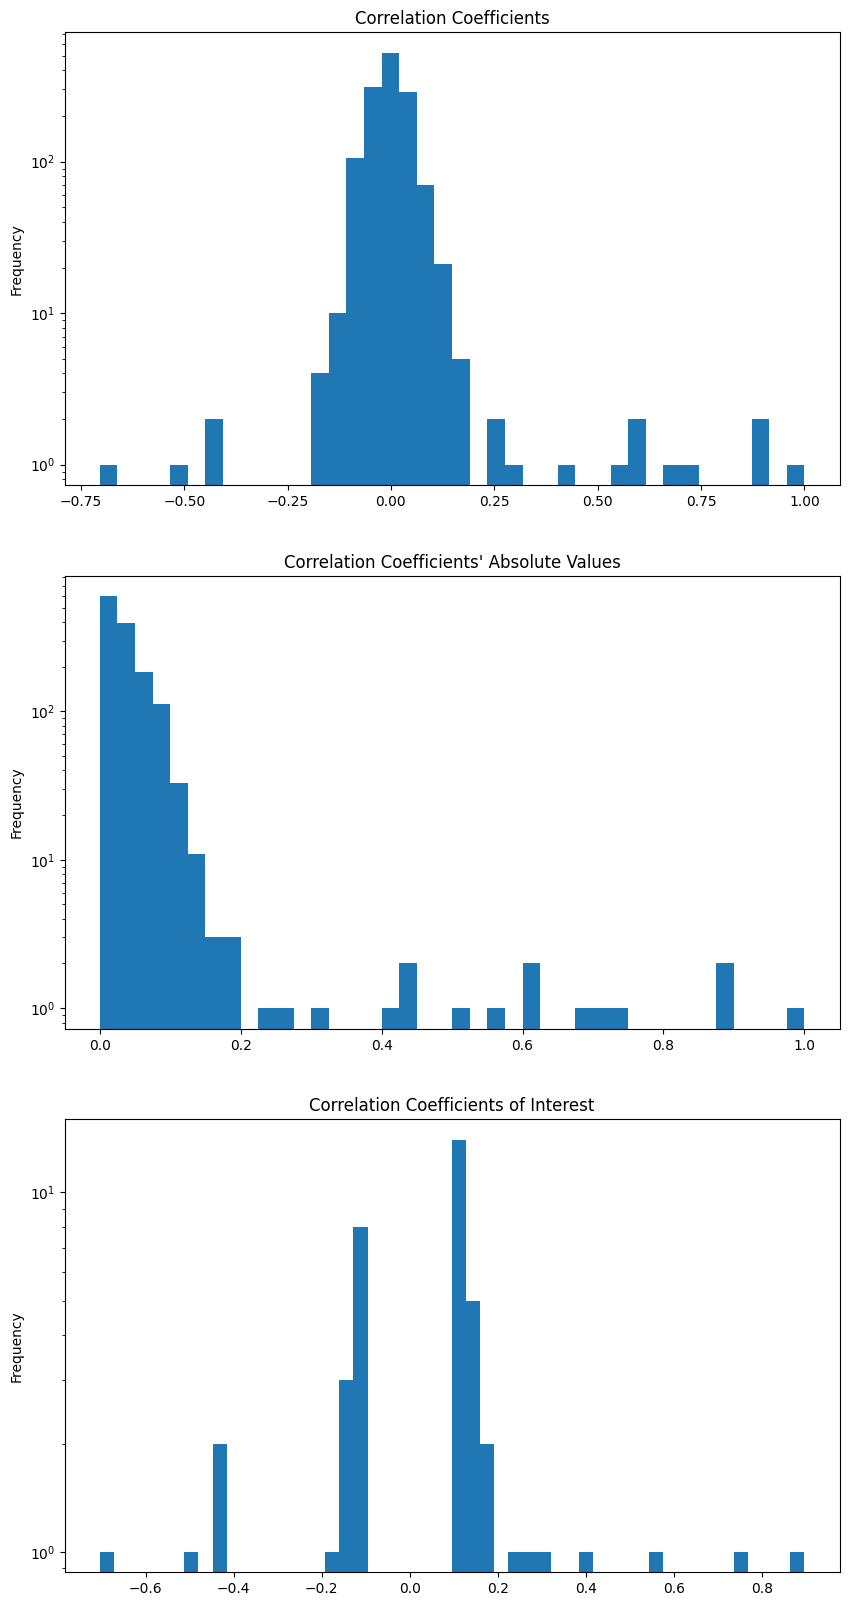

In [106]:
# drop half the entries, which are essentially duplicates,
#   as well as any np.nan entries and entries with low correlation coefficients or exceedingly high correlation coefficients,
#   which have already been considered previously or present trivial correlation information
#   (ie the number of individuals under 5 years of age is directly correlated with the total population)
merged_corr_sorted, merged_corrs_of_interest = do_corr_analysis(merged_corr, 0.1, 1, "state_name|division_name|pug_agency_name|index|incident_id", merged_corr_sorted)

In [107]:
merged_corrs_of_interest

index                                           feature1  \
943     369                              transformed_data_year   
1207   1234               transformed_total_individual_victims   
1217    869                   transformed_adult_offender_count   
1581    623                  transformed_juvenile_victim_count   
1809    619                  transformed_juvenile_victim_count   
2023    500                     transformed_adult_victim_count   
2043    622                  transformed_juvenile_victim_count   
2121    865                   transformed_adult_offender_count   
3185   1239               transformed_total_individual_victims   
3949    501                     transformed_adult_victim_count   
4299    867                   transformed_adult_offender_count   
5429     71                                transformed_level_0   
5519    625                  transformed_juvenile_victim_count   
6059    990                transformed_juvenile_offender_count   
6205    113                                transformed_level_0   
6309      8                                transformed_level_0   
6329   1035                transformed_juvenile_offender_count   
6367    748                   transformed_total_offender_count   
6459    107                                transformed_level_0   
6463     19                                transformed_level_0   
6541    377                              transformed_data_year   
6683    870                   transformed_adult_offender_count   
6785   5789                transformed_Percent!!15 to 19 years   
6831    743                   transformed_total_offender_count   
6957     79                                transformed_level_0   
7001  12300  transformed_Percent!!Race alone or in combinat...   
7085    102                                transformed_level_0   
7097   5666                transformed_Percent!!10 to 14 years   
7109   6280                transformed_Percent!!45 to 54 years   
7129     45                                transformed_level_0   
7197   1043                transformed_juvenile_offender_count   
7213    615                  transformed_juvenile_victim_count   
7259   6650                transformed_Percent!!65 to 74 years   
7289    908                   transformed_adult_offender_count   
7325     57                                transformed_level_0   
7327    105                                transformed_level_0   
7335    864                   transformed_adult_offender_count   
7345  10086  transformed_Percent!!RACE!!One race!!Asian!!Vi...   
7347  13530  transformed_Percent!!HISPANIC OR LATINO AND RA...   
7385   5418                 transformed_Percent!!Under 5 years   
7435     58                                transformed_level_0   
7445    916                   transformed_adult_offender_count   
7479   5658                transformed_Percent!!10 to 14 years   
7483   1041                transformed_juvenile_offender_count   

                                               feature2      corr  abs_corr  
943                                 transformed_level_0  0.896233  0.896233  
1207                     transformed_adult_victim_count  0.740256  0.740256  
1217                transformed_juvenile_offender_count -0.704027  0.704027  
1581                transformed_juvenile_offender_count  0.554362  0.554362  
1809                     transformed_adult_victim_count -0.502943  0.502943  
2023                transformed_juvenile_offender_count -0.437794  0.437794  
2043                   transformed_adult_offender_count -0.433849  0.433849  
2121                     transformed_adult_victim_count  0.411115  0.411115  
3185                           transformed_victim_count  0.302968  0.302968  
3949                           transformed_victim_count  0.261609  0.261609  
4299                   transformed_total_offender_count  0.239825  0.239825  
5429  transformed_Percent!!RACE!!One race!!American ... -0.190744  0.190744  
5519               tr

In [108]:
merged_corrs_of_interest.iloc[0]["feature1"]

'transformed_data_year'

####Other Figures

<Axes: xlabel='victim_types_Other', ylabel='Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Some Other Race alone'>

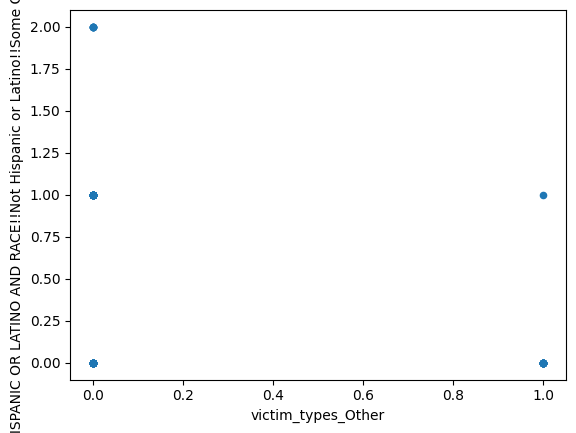

In [109]:
merged_df.plot.scatter(x="victim_types_Other", y="Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino!!Some Other Race alone")

###County Feature Prediction Dataset

In [110]:
county_hate_rates_df.head()

transformed_Total population  \
0                           NaN   
1                      0.734023   
2                      0.208167   
3                           NaN   
4                      1.070448   

   transformed_Sex ratio (males per 100 females)  transformed_Under 5 years  \
0                                            NaN                        NaN   
1                                       0.049318                   0.853570   
2                                       1.291092                   0.138859   
3                                            NaN                        NaN   
4                                      -0.233425                   1.018115   

   transformed_5 to 9 years  transformed_10 to 14 years  \
0                       NaN                         NaN   
1                  0.800190                    0.826586   
2                  0.219807                    0.005688   
3                       NaN                         NaN   
4                  1.133067                    1.057093   

   transformed_15 to 19 years  transformed_20 to 24 years  \
0                         NaN                         NaN   
1                    0.638037                    0.633396   
2                    0.089234                    0.440456   
3                         NaN                         NaN   
4                    1.011768                    0.870062   

   transformed_25 to 34 years  transformed_35 to 44 years  \
0                         NaN                         NaN   
1                    0.675680                    0.652045   
2                    0.306196                    0.146521   
3                         NaN                         NaN   
4                    0.999195                    1.140302   

   transformed_45 to 54 years  transformed_55 to 59 years  \
0                         NaN                         NaN   
1                    0.729067                    0.656743   
2                    0.177260                    0.169561   
3                         NaN                         NaN   
4                    1.118772                    1.057093   

   transformed_60 to 64 years  transformed_65 to 74 years  \
0                         NaN                         NaN   
1                    0.805424                    0.734023   
2                    0.282435                    0.158031   
3                         NaN                         NaN   
4                    1.111709                    0.992967   

   transformed_75 to 84 years  transformed_85 years and over  \
0                         NaN                            NaN   
1                    0.734023                       0.962388   
2                    0.138859                       0.382667   
3                         NaN                            NaN   
4                    1.043924                       0.898090   

   transformed_Median age (years)  transformed_Under 18 years  \
0                             NaN                         NaN   
1                       -0.194623                    0.831934   
2                       -0.346192                    0.102568   
3                             NaN                         NaN   
4                       -0.020858                    1.077198   

   transformed_16 years and over  transformed_21 years and over  \
0                            NaN                            NaN   
1                       0.709421                       0.719209   
2                       0.215924                       0.223694   
3                            NaN                            NaN   
4                       1.057093                       1.057093   

   transformed_62 years and over  transformed_18 years and over  \
0                            NaN                            NaN   
1                       0.759077                       0.709421   
2                       0.188829                       0.219807   
3                            NaN               

####Correlation Analysis

In [111]:
hate_rate_corr = county_hate_rates_df[hate_rate_numerical_cols].corr()

In [112]:
hate_rate_corr.head()

transformed_Total population  \
transformed_Total population                                       1.000000   
transformed_Sex ratio (males per 100 females)                     -0.200382   
transformed_Under 5 years                                          0.933711   
transformed_5 to 9 years                                           0.916300   
transformed_10 to 14 years                                         0.922732   

                                               transformed_Sex ratio (males per 100 females)  \
transformed_Total population                                                       -0.200382   
transformed_Sex ratio (males per 100 females)                                       1.000000   
transformed_Under 5 years                                                          -0.179260   
transformed_5 to 9 years                                                           -0.184489   
transformed_10 to 14 years                                                         -0.198378   

                                               transformed_Under 5 years  \
transformed_Total population                                    0.933711   
transformed_Sex ratio (males per 100 females)                  -0.179260   
transformed_Under 5 years                                       1.000000   
transformed_5 to 9 years                                        0.948934   
transformed_10 to 14 years                                      0.947578   

                                               transformed_5 to 9 years  \
transformed_Total population                                   0.916300   
transformed_Sex ratio (males per 100 females)                 -0.184489   
transformed_Under 5 years                                      0.948934   
transformed_5 to 9 years                                       1.000000   
transformed_10 to 14 years                                     0.902953   

                                               transformed_10 to 14 years  \
transformed_Total population                                     0.922732   
transformed_Sex ratio (males per 100 females)                   -0.198378   
transformed_Under 5 years                                        0.947578   
transformed_5 to 9 years                                         0.902953   
transformed_10 to 14 years                                       1.000000   

                                               transformed_15 to 19 years  \
transformed_Total population                                     0.926206   
transformed_Sex ratio (males per 100 females)                   -0.193000   
transformed_Under 5 years                                        0.924006   
transformed_5 to 9 years                                         0.904423   
transformed_10 to 14 years                                       0.917348   

                                               transformed_20 to 24 years  \
transformed_Total population                                     0.877309   
transformed_Sex ratio (males per 100 females)                   -0.152741   
transformed_Under 5 years                                        0.891922   
transformed_5 to 9 years                                         0.851403   
transformed_10 to 14 years                                       0.854016   

                                               transformed_25 to 34 years  \
transformed_Total population                                     0.941224   
transformed_Sex ratio (males per 100 females)                   -0.149476   
transformed_Under 5 years                                        0.948812   
transformed_5 to 9 years                                         0.937855   
transformed_10 to 14 years                                       0.915271   

                                               transformed_35 to 44 years  \
transformed_Total population                                     0.959838   
transformed_Sex ratio (males per 100 females)                   -0.166315   
tran

In [113]:
# # Set the figure size
# plt.figure(figsize=(100, 50))

# # Create a heatmap of the correlation matrix
# sns.heatmap(hate_rate_corr, annot=True)

# # Show the plot
# plt.show()

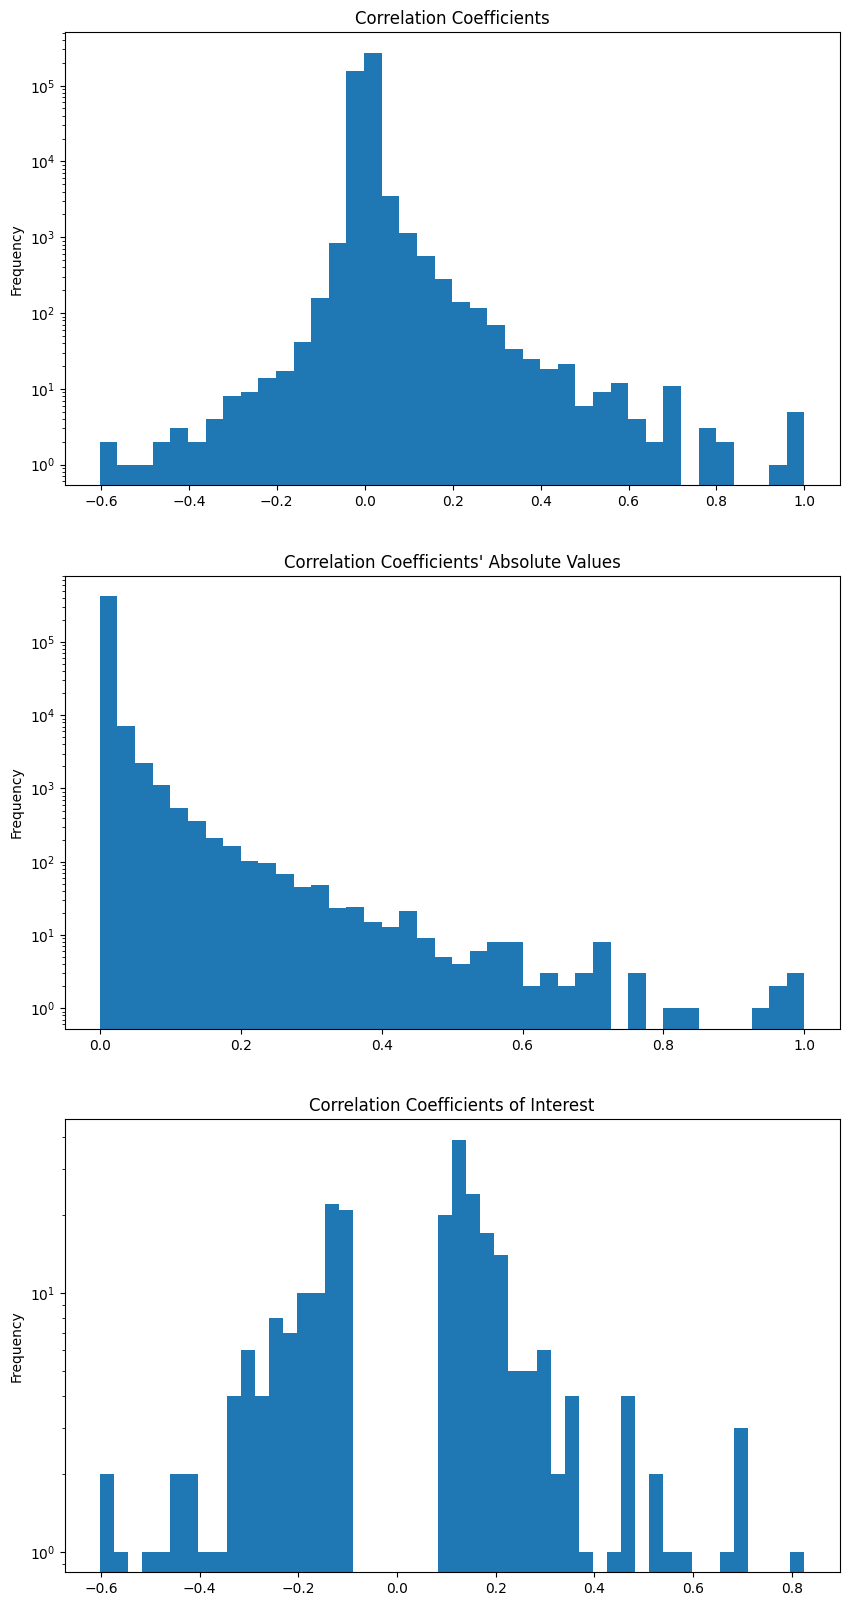

In [114]:
extracted_sorted_corrs, extracted_corrs_of_interest = do_corr_analysis(hate_rate_corr["transformed_hate_crime_rate"], 0.1, 1.01, "state_name|division_name|pug_agency_name")

In [115]:
extracted_corrs_of_interest

index                                           feature1  \
942      6114                           total_individual_victims   
954     49992                        victim_types_Society/Public   
962     94817        location_name_Abandoned/Condemned Structure   
968    102967       location_name_Church/Synagogue/Temple/Mosque   
974      5101                                       victim_count   
986     45904                            victim_types_Individual   
988    981245            offender_race_Black or African American   
992      6159                           total_individual_victims   
1014   991438                         offender_ethnicity_Unknown   
1018     5095                                       victim_count   
1030     3059                               adult_offender_count   
1034    61189             offense_name_Drug Equipment Violations   
1036   986339                                offender_race_White   
1052     6112                                       victim_count   
1054     4077                            juvenile_offender_count   
1056    91759                 offense_name_Weapon Law Violations   
1062    62204              offense_name_Drug/Narcotic Violations   
1066       45                                 adult_victim_count   
1070   989401          offender_ethnicity_Not Hispanic or Latino   
1094     3061                               adult_offender_count   
1104     4206                            juvenile_offender_count   
1112    49937                        victim_types_Society/Public   
1134    43862                              victim_types_Business   
1138        1                                 adult_victim_count   
1170    72432                          offense_name_Intimidation   
1174   132471          location_name_School-Elementary/Secondary   
1182   987413                        offender_ethnicity_Multiple   
1184     3001                               total_offender_count   
1196     2042                               total_offender_count   
1212    48947                victim_types_Religious Organization   
1220    49931                        victim_types_Society/Public   
1232   985324                              offender_race_Unknown   
1234    61185             offense_name_Drug Equipment Violations   
1260     6175                           total_individual_victims   
1262   991434                         offender_ethnicity_Unknown   
1314    96831                       location_name_Amusement Park   
1322    46919               victim_types_Law Enforcement Officer   
1326   118330   location_name_Highway/Road/Alley/Street/Sidewalk   
1334     3187                               adult_offender_count   
1362    97850   location_name_Arena/Stadium/Fairgrounds/Coliseum   
1372     6157                           total_individual_victims   
1374   990421                   offender_ethnicity_Not Specified   
1380    45899                            victim_types_Individual   
1382    50047                        victim_types_Society/Public   
1384   102954       location_name_Church/Synagogue/Temple/Mosque   
1386    43899                              victim_types_Business   
1400   102931       location_name_Church/Synagogue/Temple/Mosque   
1402    99919                location_name_Bank/Savings and Loan   
1410    14308           bias_desc_Anti-Black or African American   
1420    44895                            victim_types_Government   
1422        4                                 adult_victim_count   
1430    10303                                bias_desc_Anti-Arab   
1448        3                                 adult_victim_count   
1474    62275              offense_name_Drug/Narcotic Violations   
1520    79531          offense_name_Pornography/Obscene Material   
1522      130                                 adult_victim_count   
1524       61                                 adult_victim_count   
1530    48957                victim_types_Religious Organization

In [116]:
# look at just the correlations between the hate crime rate and other features
hate_rate_corr.loc["transformed_hate_crime_rate"].sort_values(ascending=False)

transformed_hate_crime_rate                                                                                                                                  1.000000
transformed_hate_crime_count                                                                                                                                 0.680501
transformed_Percent!!Race alone or in combination with one or more other races!!White                                                                        0.182672
transformed_Percent!!RACE!!One race!!White                                                                                                                   0.180005
transformed_Percent!!RACE!!One race                                                                                                                          0.140382
transformed_Percent!!HISPANIC OR LATINO AND RACE!!Not Hispanic or Latino                                                                                     0.133179
tran

####Scatter Plots

<Axes: xlabel='transformed_Under 5 years', ylabel='transformed_hate_crime_rate'>

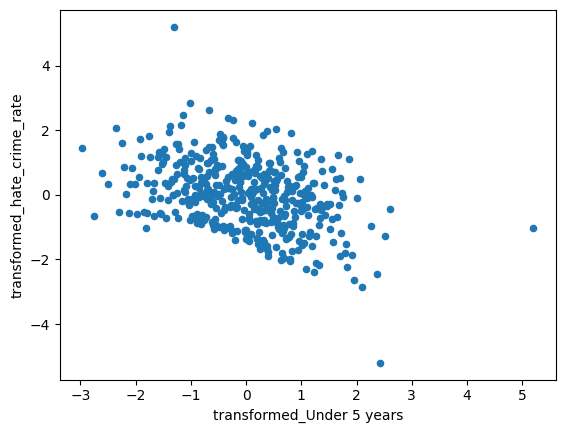

In [117]:
county_hate_rates_df.plot.scatter(x="transformed_Under 5 years", y="transformed_hate_crime_rate")

<Axes: xlabel='transformed_15 to 19 years', ylabel='transformed_hate_crime_rate'>

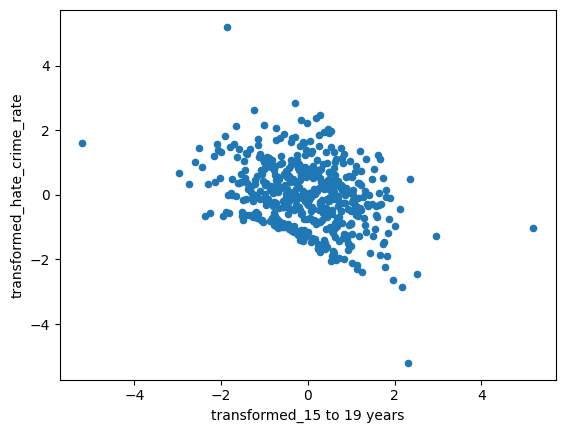

In [118]:
county_hate_rates_df.plot.scatter(x="transformed_15 to 19 years", y="transformed_hate_crime_rate")

<Axes: xlabel='transformed_65 years and over', ylabel='transformed_hate_crime_rate'>

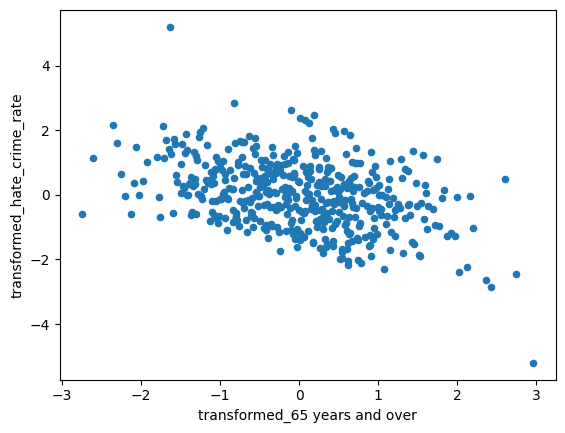

In [119]:
county_hate_rates_df.plot.scatter(x="transformed_65 years and over", y="transformed_hate_crime_rate")

<Axes: xlabel='transformed_Percent!!75 to 84 years', ylabel='transformed_hate_crime_rate'>

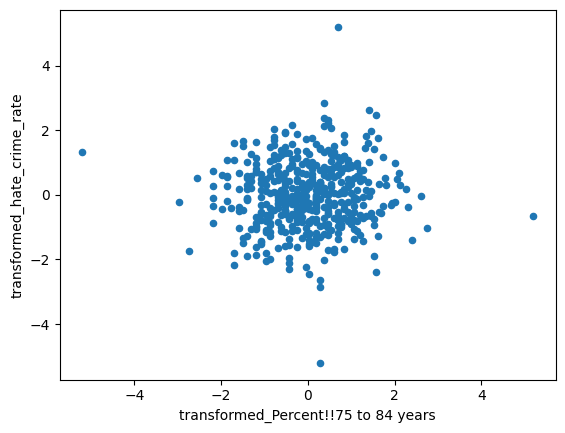

In [120]:
county_hate_rates_df.plot.scatter(x="transformed_Percent!!75 to 84 years", y="transformed_hate_crime_rate")

<Axes: xlabel='transformed_Percent!!RACE!!One race!!White', ylabel='transformed_hate_crime_rate'>

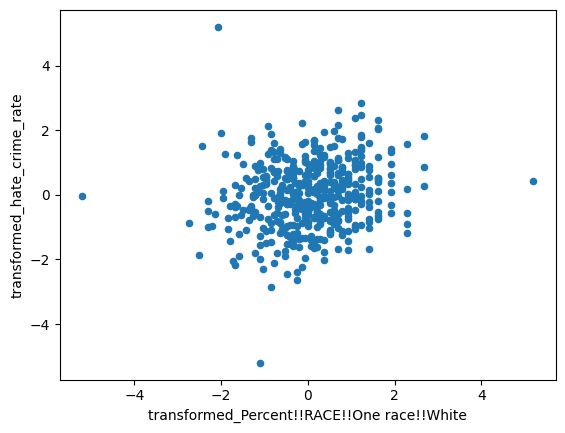

In [121]:
county_hate_rates_df.plot.scatter(x="transformed_Percent!!RACE!!One race!!White", y="transformed_hate_crime_rate")

<Axes: xlabel='transformed_Percent!!RACE!!One race', ylabel='transformed_hate_crime_rate'>

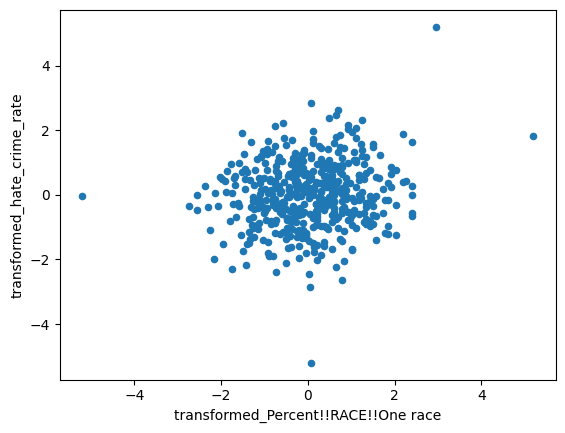

In [122]:
county_hate_rates_df.plot.scatter(x="transformed_Percent!!RACE!!One race", y="transformed_hate_crime_rate")

#Data Prediction

In [123]:
# designate the training data
training_cols = [col for col in hate_rate_numerical_cols if (not "hate_crime_rate" in col) and ("transformed_" in col)]
x_train_df = county_hate_rates_df[training_cols]
y_train_df = county_hate_rates_df["transformed_hate_crime_rate"]

# designate a single feature for viewing the model's predictions relative to its transformed value
review_feature = "transformed_Total population"

In [124]:
x_train_df.head()

transformed_Total population  \
0                           NaN   
1                      0.734023   
2                      0.208167   
3                           NaN   
4                      1.070448   

   transformed_Sex ratio (males per 100 females)  transformed_Under 5 years  \
0                                            NaN                        NaN   
1                                       0.049318                   0.853570   
2                                       1.291092                   0.138859   
3                                            NaN                        NaN   
4                                      -0.233425                   1.018115   

   transformed_5 to 9 years  transformed_10 to 14 years  \
0                       NaN                         NaN   
1                  0.800190                    0.826586   
2                  0.219807                    0.005688   
3                       NaN                         NaN   
4                  1.133067                    1.057093   

   transformed_15 to 19 years  transformed_20 to 24 years  \
0                         NaN                         NaN   
1                    0.638037                    0.633396   
2                    0.089234                    0.440456   
3                         NaN                         NaN   
4                    1.011768                    0.870062   

   transformed_25 to 34 years  transformed_35 to 44 years  \
0                         NaN                         NaN   
1                    0.675680                    0.652045   
2                    0.306196                    0.146521   
3                         NaN                         NaN   
4                    0.999195                    1.140302   

   transformed_45 to 54 years  transformed_55 to 59 years  \
0                         NaN                         NaN   
1                    0.729067                    0.656743   
2                    0.177260                    0.169561   
3                         NaN                         NaN   
4                    1.118772                    1.057093   

   transformed_60 to 64 years  transformed_65 to 74 years  \
0                         NaN                         NaN   
1                    0.805424                    0.734023   
2                    0.282435                    0.158031   
3                         NaN                         NaN   
4                    1.111709                    0.992967   

   transformed_75 to 84 years  transformed_85 years and over  \
0                         NaN                            NaN   
1                    0.734023                       0.962388   
2                    0.138859                       0.382667   
3                         NaN                            NaN   
4                    1.043924                       0.898090   

   transformed_Median age (years)  transformed_Under 18 years  \
0                             NaN                         NaN   
1                       -0.194623                    0.831934   
2                       -0.346192                    0.102568   
3                             NaN                         NaN   
4                       -0.020858                    1.077198   

   transformed_16 years and over  transformed_21 years and over  \
0                            NaN                            NaN   
1                       0.709421                       0.719209   
2                       0.215924                       0.223694   
3                            NaN                            NaN   
4                       1.057093                       1.057093   

   transformed_62 years and over  transformed_18 years and over  \
0                            NaN                            NaN   
1                       0.759077                       0.709421   
2                       0.188829                       0.219807   
3                            NaN               

##Linear Regression on All Transformed Data

In [125]:
hate_regression_model = LinearRegression()
hate_regression_model.fit(
    X=x_train_df.dropna(),
    y=y_train_df.dropna()
)

LinearRegression()

####Observe regression line for individual feature

In [126]:
coefficients = hate_regression_model.coef_
intercept = hate_regression_model.intercept_

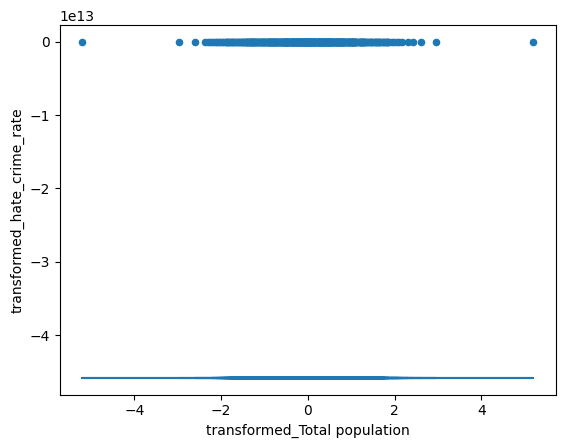

In [127]:
# create a scatter plot of the data
county_hate_rates_df.plot.scatter(x=review_feature, y="transformed_hate_crime_rate")

x = x_train_df[review_feature]
plt.plot(x, coefficients[x_train_df.columns.get_loc(review_feature)] * x + intercept)

##K-Nearest-Neighbors on Review Feature

<Axes: xlabel='transformed_Total population', ylabel='transformed_hate_crime_rate'>

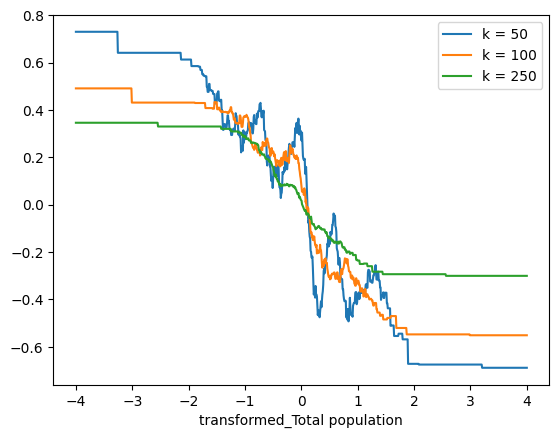

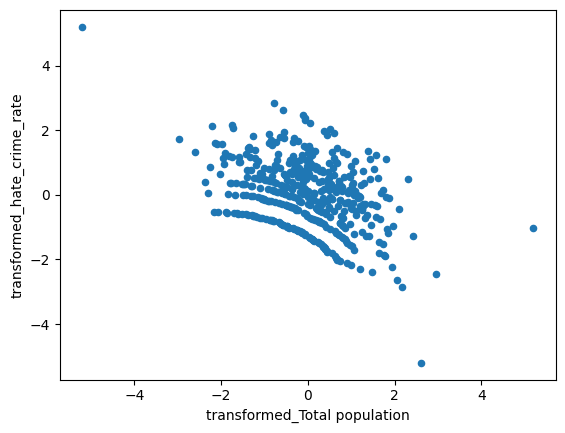

In [129]:
# reformat the training data
x_train_df = pd.DataFrame(x_train_df[review_feature]).dropna()
y_train_df.dropna(inplace=True)

# create the test data
x_test = pd.DataFrame()
x_test[review_feature] = np.linspace(-4, 4, 1000)

# try various different values of k
for k in [50, 100, 250]:
    # create and fit the model
    hate_knn_model = KNeighborsRegressor(n_neighbors=k)
    hate_knn_model.fit(X=x_train_df, y=y_train_df)

    # get the model's predictions
    y_pred = pd.Series(
        hate_knn_model.predict(x_test),
        index=x_test[review_feature]
    )

    # plot knn model predictions
    y_pred.plot.line(label=("k = " + str(k))).legend()

# create a scatter plot of the data
county_hate_rates_df.plot.scatter(x=review_feature, y="transformed_hate_crime_rate")